In [5]:
from qiskit import QuantumCircuit, transpile
# from qiskit.providers.aer import QasmSimulator
# from qiskit.providers.basicaer import QasmSimulatorPy
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakeManila, FakeToronto, FakeJakartaV2, FakeProvider
from qiskit.circuit import Parameter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import QDrift, LieTrotter, SuzukiTrotter

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn.preprocessing as skp
from scipy.signal import savgol_filter
import os
import sys
from datetime import date
import pathlib
import inspect
import time
import glob

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('..')) # qrc_surrogate
sys.path.append(module_path)
fig_path = f'{module_path}/figs'


from src.feedforward import QExtremeLearningMachine, CPolynomialFeedforward
from src.rewinding import QRewindingRC, QRewindingStatevectorRC,  QRewindingRC_Neat
from src.data import DataSource

from iqm.qiskit_iqm import IQMFakeAdonis
from iqm.qiskit_iqm import IQMProvider,transpile_to_IQM,optimize_single_qubit_gates

server_url = "https://cocos.resonance.meetiqm.com/garnet"  # For example https://cocos.resonance.meetiqm.com/garnet
api_token = "287K1FQqLZ9JU+FxO6C4l6TXENKy0SFUO8h5P4po3DIGZeGb5qhzo4AAi21PIAqd"

SHOTS = 8000

IQMbackend = IQMProvider(server_url, token=api_token).get_backend()

In [6]:
sim_Backend=AerSimulator()

In [11]:

Meas_List=[] # we need to keep this for set-up of the final circuits.

# We produce a custom version of the "manual constuction".
Manual_Layout_List=[]
nmem = 3
nsteps=2
for step in range(2):
    memory_qubits=list(range(nmem))
    data_qubits=list(range(nmem+step*2,nmem+(step+1)*2))
    Manual_Layout_List+= [memory_qubits + data_qubits]
print(Manual_Layout_List)
if max(Manual_Layout_List[-1])>7:
    print('warning: circuit too large for backend!')
    qc = QuantumCircuit(Manual_Layout_List[-1],Manual_Layout_List[-1])
else:
#Overall circuit!
    qc = QuantumCircuit(7, 7)

#And the current circuit.
c_circuit = QuantumCircuit(5,2)



    

#Manually create a swap:
cSWAP=QuantumCircuit(2,0)
cSWAP.swap(0,1)
#gSWAP=transpile(cSWAP, basis_gates=['r', 'cz'], optimization_level = 0)

#For the automatic circuits, we use the qiskit gates and allow transpilation.

    

theta_list=[Parameter('theta_'+str(i)) for i in range(len(Manual_Layout_List[0]))]
for step in range(nsteps): # Loop over all steps used..:
    c_qubits=Manual_Layout_List[step]
    # Add undefined inputs:
    qn = 0 # qubit counter for loop
    for c in range(1):
        for d in range(int(2 /1)): # dimx
            phi_c = Parameter('phi_'+str(step)+'_'+str(qn))
            
            #print(step,qn,c_qubits[self.memory_size+0*self.dimxqc+self.qin[qn]])
            if True:
                match 'x':
                    case 'x':
                        qc.rx(theta=phi_c,qubit=c_qubits[3+[0,1][qn]])
                    case 'y':
                        qc.ry(theta=phi_c, qubit=c_qubits[3+[0,1][qn]])
                    case 'z':
                        qc.rz(phi=phi_c, qubit=c_qubits[3+[0,1][qn]])
                    case _:
                        raise Warning(f'Invalid encaxes={self.encaxes}')
            elif False: 
                self.encaxes = ['ry', 'rz']
                qc.h(qubit=self.memory_size+0*self.dimxqc+self.qin[qn])
                qc.ry(np.arctan(phi_c) + np.pi/4, qubit=self.memory_size+step*self.dimxqc+self.qin[qn])
                qc.rz(np.arctan(phi_c**2) + np.pi/4, qubit=self.memory_size+step*self.dimxqc+self.qin[qn])

                
            else:
                raise Warning(f'Invalid enctype {self.enctype}')
            qn += 1
        
            

        
    for i in range(len(c_qubits)):
        #H
        qc.h(qubit=c_qubits[i])
        #qc.r(theta=np.pi,phi=0, qubit=c_qubits[i])



    # CZ
    for i in range(len(c_qubits)-1):
        qc.cz(control_qubit=c_qubits[i],target_qubit=c_qubits[i+1])
    qc.cz(control_qubit=c_qubits[-1],target_qubit=c_qubits[0])

    #XROT
    for i in range(len(c_qubits)):
        #X
        
        qc.rx(theta=theta_list[i],qubit=c_qubits[i])
        #H
        qc.h(qubit=c_qubits[i])
        #qc.r(theta=np.pi,phi=0, qubit=c_qubits[i])

        

        




    #We will keep track of which measurements to perform here:
    if 2 > 0:
        adj_meas=[k + 3 for k in [0,1]]
        
        Meas_List  += [[Manual_Layout_List[step][k] for k in adj_meas]]

#In the last step, we measure ALL qubits.
Meas_List=Manual_Layout_List[-1]

#We now have to transpile the circuit!
## define the circuit to be run on the hardware
#opt_level = self.opt_level ## defines the optimization level


#Not necessary...

#if (self.QPU == 'Apollo'):
#    qubit_names = ["QB3", "QB8", "QB4", "QB9", "QB13", "QB14", "QB5", "QB10", "QB15", "QB6", "QB11", "QB16", "QB7", "QB12", "QB17", "QB18", "QB19", "QB20", "QB1", "QB2"]
#elif (self.QPU == 'Adonis'):
#    qubit_names = ["QB1", "QB3", "QB2", "QB4", "QB5"]

# We allow qiskit to perform transpilation!
#tqc = transpile(qc,backend=self.backend,optimization_level=opt_level)
# We need to see how the qubits have been permuted:
#perm_lib_qiskit=tqc.layout.initial_layout
# This is the wrong form for our purposes: we need to swap it:

#meas_mapping={perm_lib_qiskit[k].index:k for k in range(self.backend.num_qubits)}

#self.all_meas=[[meas_mapping[i] for i in k] for k in self.all_meas]






[[0, 1, 2, 3, 4], [0, 1, 2, 5, 6]]


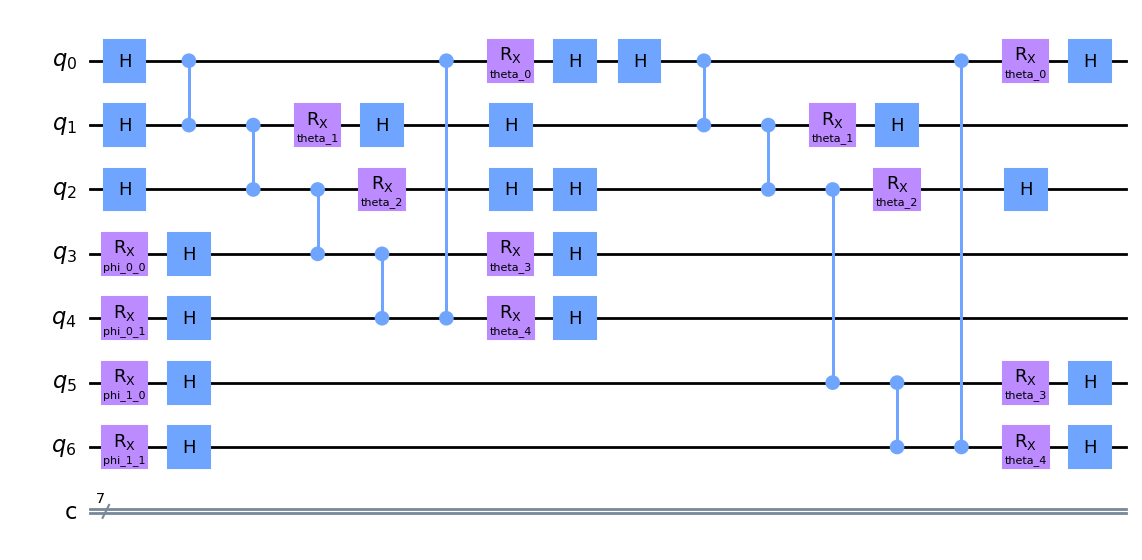

In [12]:
qc.draw('mpl')

In [14]:
param_map={k.name:k for k in qc.parameters}
param_map

{'phi_0_0': Parameter(phi_0_0),
 'phi_0_1': Parameter(phi_0_1),
 'phi_1_0': Parameter(phi_1_0),
 'phi_1_1': Parameter(phi_1_1),
 'theta_0': Parameter(theta_0),
 'theta_1': Parameter(theta_1),
 'theta_2': Parameter(theta_2),
 'theta_3': Parameter(theta_3),
 'theta_4': Parameter(theta_4)}

In [17]:
subbed_theta_qc=qc.assign_parameters({param_map['theta_0']:2.84,param_map['theta_1']:-4.5,param_map['theta_2']:9.08,param_map['theta_3']:9.57,param_map['theta_4']:6.37})

In [41]:
example_qc=subbed_theta_qc.assign_parameters({param_map['phi_0_0']:np.pi*4/5,param_map['phi_1_0']:np.pi*4/5,param_map['phi_0_1']:0.15343628*np.pi,param_map['phi_1_1']:0.76013439*np.pi})
example_qc.save_statevector()

In [44]:
from qiskit import execute

In [43]:
backend = AerSimulator(method='statevector')
job = execute(example_qc, backend=backend, shots=1, memory=True)
job_result = job.result()
s1=job_result.get_statevector(example_qc)

In [44]:
example_qc=subbed_theta_qc.assign_parameters({param_map['phi_0_0']:np.pi*4/5,param_map['phi_1_0']:np.pi*4/5,param_map['phi_0_1']:0*np.pi,param_map['phi_1_1']:0*np.pi})
example_qc.save_statevector()

In [45]:
backend = AerSimulator(method='statevector')
job = execute(example_qc, backend=backend, shots=1, memory=True)
job_result = job.result()
s2=job_result.get_statevector(example_qc)

In [50]:
X = np.linspace(0,np.pi,101)
Y = np.linspace(0,np.pi,101)
Z=np.zeros([101,101])
for i in range(101):
    for j in range(101):
        example_qc=subbed_theta_qc.assign_parameters({param_map['phi_0_0']:np.pi*4/5,param_map['phi_1_0']:np.pi*4/5,param_map['phi_0_1']:X[i],param_map['phi_1_1']:Y[j]})
        example_qc.save_statevector()
        job = execute(example_qc, backend=backend, shots=1, memory=True)
        job_result = job.result()
        sc=job_result.get_statevector(example_qc)
        Z[i,j]=np.linalg.norm(sc-s2)
X, Y = np.meshgrid(X, Y)


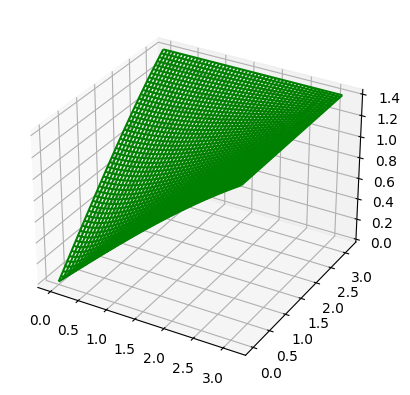

In [55]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt


fig = plt.figure()
wf = fig.add_subplot(111, projection='3d')

wf.plot_wireframe(X,Y,Z, rstride=2, 
                  cstride=2,color='green')
plt.show()

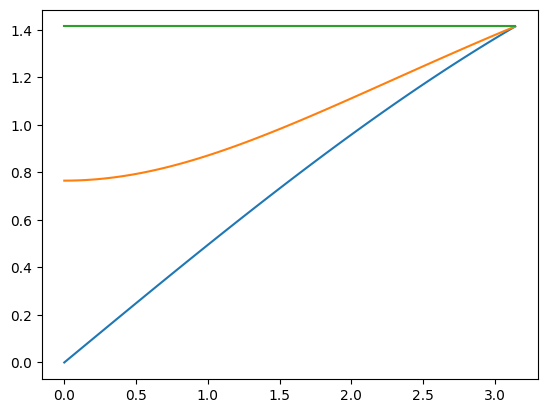

In [58]:
plt.plot(X[0],Z[0])
plt.plot(X[50],Z[50])
plt.plot(X[100],Z[100])


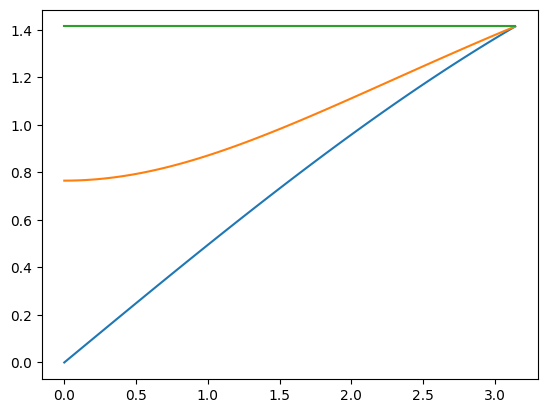

In [63]:
plt.plot(X[0],Z[0,:])
plt.plot(X[50],Z[50,:].reshape(101,1))
plt.plot(X[100],Z[100,:].reshape(101,1))


In [64]:
Z[0:5,0:5]

array([[0.        , 0.0157078 , 0.03141463, 0.04711953, 0.06282152],
       [0.0157078 , 0.0222135 , 0.03512111, 0.049666  , 0.06475177],
       [0.03141463, 0.03512111, 0.04442152, 0.05662185, 0.07022446],
       [0.04711953, 0.049666  , 0.05662185, 0.06661858, 0.07850103],
       [0.06282152, 0.06475177, 0.07022446, 0.07850103, 0.0887992 ]])

In [1]:
from qiskit.quantum_info.operators.symplectic import Pauli

In [75]:
s2.expectation_value(Pauli('IIIIIIZ'))

0.0

In [365]:
def Simulated_Reservoir(nsteps_in,enc):
    
    Meas_List=[] # we need to keep this for set-up of the final circuits.

    # We produce a custom version of the "manual constuction".
    Manual_Layout_List=[]
    nmem = 3
    nsteps=nsteps_in
    for step in range(nsteps):
        memory_qubits=list(range(nmem))
        data_qubits=list(range(nmem+step*2,nmem+(step+1)*2))
        Manual_Layout_List+= [memory_qubits + data_qubits]
    print(Manual_Layout_List)
    if max(Manual_Layout_List[-1])>nmem+2*nsteps:
        print('warning: circuit too large for backend!')
        qc = QuantumCircuit(Manual_Layout_List[-1],Manual_Layout_List[-1])
    else:
    #Overall circuit!
        qc = QuantumCircuit(nmem+2*nsteps, nmem+2*nsteps)

    #And the current circuit.
    c_circuit = QuantumCircuit(5,2)



        

    #Manually create a swap:
    cSWAP=QuantumCircuit(2,0)
    cSWAP.swap(0,1)
    #gSWAP=transpile(cSWAP, basis_gates=['r', 'cz'], optimization_level = 0)

    #For the automatic circuits, we use the qiskit gates and allow transpilation.

        

    theta_list=[Parameter('theta_'+str(i)) for i in range(len(Manual_Layout_List[0]))]
    for step in range(nsteps): # Loop over all steps used..:
        c_qubits=Manual_Layout_List[step]
        # Add undefined inputs:
        qn = 0 # qubit counter for loop
        for c in range(1):
            for d in range(int(2 /1)): # dimx
                phi_c = Parameter('phi_'+str(step)+'_'+str(qn))
                
                #print(step,qn,c_qubits[self.memory_size+0*self.dimxqc+self.qin[qn]])
                if True:
                    match enc:
                        case 'x':
                            qc.rx(theta=phi_c,qubit=c_qubits[3+[0,1][qn]])
                        case 'y':
                            qc.ry(theta=phi_c, qubit=c_qubits[3+[0,1][qn]])
                        case 'z':
                            qc.rz(phi=phi_c, qubit=c_qubits[3+[0,1][qn]])
                        case _:
                            raise Warning(f'Invalid encaxes={self.encaxes}')
                elif False: 
                    self.encaxes = ['ry', 'rz']
                    qc.h(qubit=self.memory_size+0*self.dimxqc+self.qin[qn])
                    qc.ry(np.arctan(phi_c) + np.pi/4, qubit=self.memory_size+step*self.dimxqc+self.qin[qn])
                    qc.rz(np.arctan(phi_c**2) + np.pi/4, qubit=self.memory_size+step*self.dimxqc+self.qin[qn])

                    
                else:
                    raise Warning(f'Invalid enctype {self.enctype}')
                qn += 1
            
                

            
        for i in range(len(c_qubits)):
            #H
            qc.h(qubit=c_qubits[i])
            #qc.r(theta=np.pi,phi=0, qubit=c_qubits[i])



        # CZ
        for i in range(len(c_qubits)-1):
            qc.cz(control_qubit=c_qubits[i],target_qubit=c_qubits[i+1])
        qc.cz(control_qubit=c_qubits[-1],target_qubit=c_qubits[0])

        #XROT
        for i in range(len(c_qubits)):
            #X
            
            qc.rx(theta=theta_list[i],qubit=c_qubits[i])
            #H
            qc.h(qubit=c_qubits[i])
            #qc.r(theta=np.pi,phi=0, qubit=c_qubits[i])

            

            




        #We will keep track of which measurements to perform here:
        if 2 > 0:
            adj_meas=[k + 3 for k in [0,1]]
            
            Meas_List  += [[Manual_Layout_List[step][k] for k in adj_meas]]

    #In the last step, we measure ALL qubits.
    Meas_List=Manual_Layout_List[-1]

    #We now have to transpile the circuit!
    ## define the circuit to be run on the hardware
    #opt_level = self.opt_level ## defines the optimization level


    #Not necessary...

    #if (self.QPU == 'Apollo'):
    #    qubit_names = ["QB3", "QB8", "QB4", "QB9", "QB13", "QB14", "QB5", "QB10", "QB15", "QB6", "QB11", "QB16", "QB7", "QB12", "QB17", "QB18", "QB19", "QB20", "QB1", "QB2"]
    #elif (self.QPU == 'Adonis'):
    #    qubit_names = ["QB1", "QB3", "QB2", "QB4", "QB5"]

    # We allow qiskit to perform transpilation!
    #tqc = transpile(qc,backend=self.backend,optimization_level=opt_level)
    # We need to see how the qubits have been permuted:
    #perm_lib_qiskit=tqc.layout.initial_layout
    # This is the wrong form for our purposes: we need to swap it:

    #meas_mapping={perm_lib_qiskit[k].index:k for k in range(self.backend.num_qubits)}

    #self.all_meas=[[meas_mapping[i] for i in k] for k in self.all_meas]

    return qc, Meas_List




In [5]:
[qc3,Meas3] = Simulated_Reservoir(3)

[[0, 1, 2, 3, 4], [0, 1, 2, 5, 6], [0, 1, 2, 7, 8]]


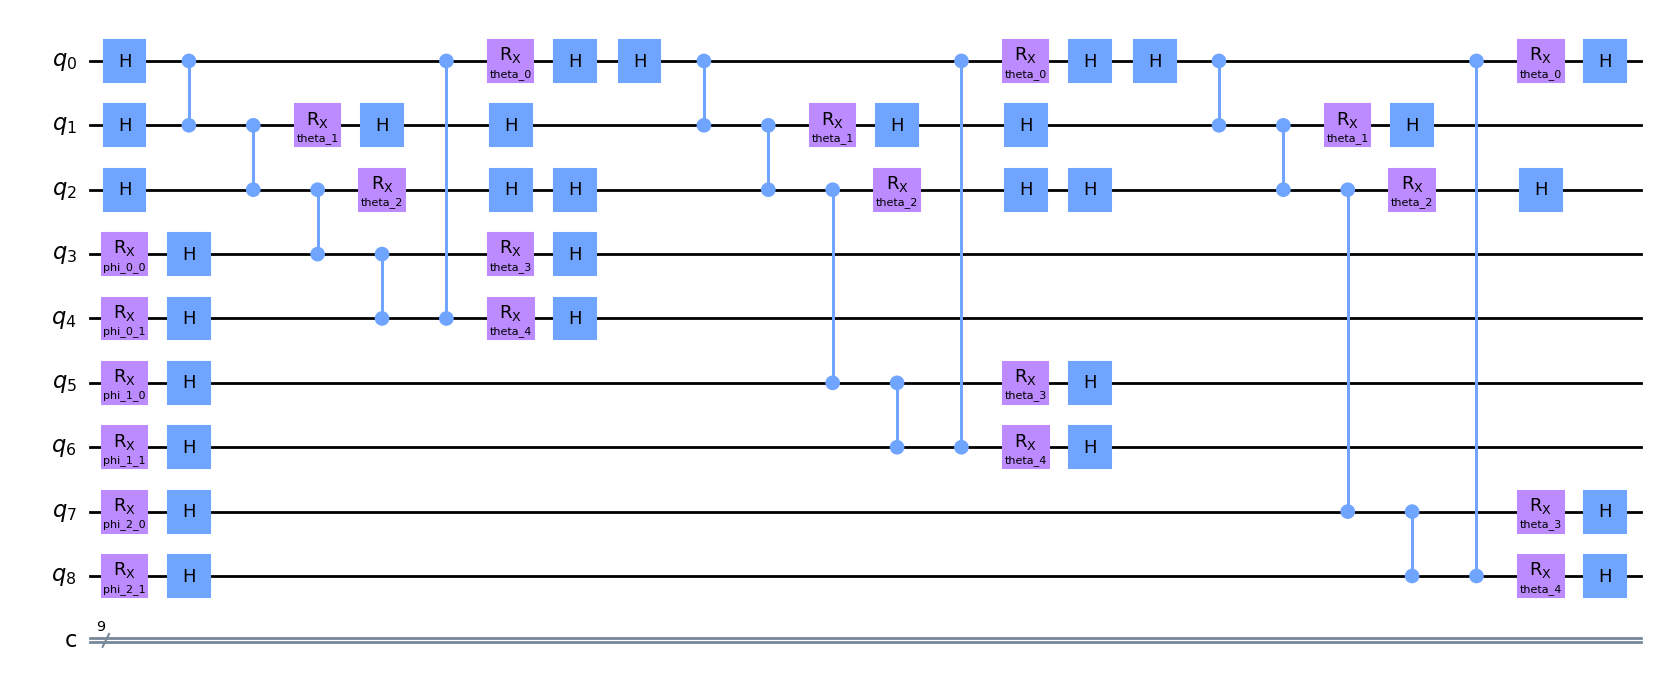

In [6]:
qc3.draw('mpl')

In [38]:
len(qc3.qubits)

9

In [15]:
from itertools import product

In [25]:
list(''.join(k) for k in product('IZ',repeat=3))

['III', 'IIZ', 'IZI', 'IZZ', 'ZII', 'ZIZ', 'ZZI', 'ZZZ']

In [410]:
def Evaluate_Features(qc,nmem,nin,nsteps,phi,theta):
    param_map={k.name:k for k in qc.parameters}
    shape_phi=phi.shape
    phi_assignment={param_map['phi_%s_%s' % (k,s)]:phi[k,s] for k in range(shape_phi[0]) for s in range(shape_phi[1])}
    theta_assignment={param_map['theta_%s' % k]:theta[k] for k in range(len(theta))}
    explicit_val=qc.assign_parameters(phi_assignment)
    explicit_val=explicit_val.assign_parameters(theta_assignment)
    explicit_val.save_statevector()
    backend = AerSimulator(method='statevector')
    job = execute(explicit_val, backend=backend, shots=1, memory=True)
    job_result = job.result()
    sv=job_result.get_statevector(explicit_val)

    #Need expectation values!
    nqubits=len(qc.qubits)
    XL = []
    YL = []
    ZL = []
    partialX=list(''.join(k) for k in product('IX',repeat=nin))
    partialY=list(''.join(k) for k in product('IY',repeat=nin))
    partialZ=list(''.join(k) for k in product('IZ',repeat=nin))
    for i in range(nsteps-1):
        XL += [('I'*nmem)+(k)+('I'*(nsteps-1-i)) for k in partialX ]
        YL += [('I'*nmem)+(k)+('I'*(nsteps-1-i)) for k  in partialY ]
        ZL += [('I'*nmem)+(k)+('I'*(nsteps-1-i)) for k  in partialZ ]
    
    
    #Now add manually the final measurements:
    fbody=3
    original_meas_x=['I'*(nmem+nin-fcurr)+'X'*fcurr for fcurr in range(1,fbody+1)]
    original_meas_y=['I'*(nmem+nin-fcurr)+'Y'*fcurr for fcurr in range(1,fbody+1)]
    original_meas_z=['I'*(nmem+nin-fcurr)+'Z'*fcurr for fcurr in range(1,fbody+1)]
    for fcurr in range(fbody):
        xstrings=list(set(list(''.join(k) for k in permutations(original_meas_x[fcurr], nmem+nin))))
        xfinal=[k[0:nmem]+'I'*(nin*(nsteps-1))+k[nmem:] for k in xstrings]
        XL += xfinal
        ystrings=list(set(list(''.join(k) for k in permutations(original_meas_y[fcurr], nmem+nin))))
        yfinal=[k[0:nmem]+'I'*(nin*(nsteps-1))+k[nmem:] for k in ystrings]
        YL += yfinal
        zstrings=list(set(list(''.join(k) for k in permutations(original_meas_z[fcurr], nmem+nin))))
        zfinal=[k[0:nmem]+'I'*(nin*(nsteps-1))+k[nmem:] for k in zstrings]
        ZL += zfinal
    print(ZL)
    #use [::-1] as Qiskit opposite of what I think!
    X = [sv.expectation_value(Pauli(k[::-1])) for k in XL]
    Y = [sv.expectation_value(Pauli(k[::-1])) for k in YL]
    Z = [sv.expectation_value(Pauli(k[::-1])) for k in ZL]

    return X,Y,Z,explicit_val




In [252]:
'IZ'[::-1]

'ZI'

In [178]:
[X0,Y0,Z0]=Evaluate_Features(qc3,3,2,3,np.zeros([3,2]),np.zeros([5]))

In [69]:
list(set(list(''.join(k) for k in permutations('IIIZ', 4))))

['ZIII', 'IIIZ', 'IIZI', 'IZII']

In [8]:
tphi=np.array([[0,1],[2,3],[4,5]])
tshape=tphi.shape

['IIIIIII', 'IIIIZII', 'IIIZIII', 'IIIZZII', 'IIIIII', 'IIIIZI', 'IIIZII', 'IIIZZI', 'IIIIIIIIZ', 'IIZIIIIII', 'ZIIIIIIII', 'IIIIIIIZI', 'IZIIIIIII', 'ZIZIIIIII', 'ZZIIIIIII', 'IIZIIIIIZ', 'ZIIIIIIIZ', 'IZIIIIIZI', 'IZIIIIIIZ', 'IZZIIIIII', 'IIIIIIIZZ', 'IIZIIIIZI', 'ZIIIIIIZI', 'IIZIIIIZZ', 'ZIIIIIIZZ', 'IZZIIIIIZ', 'ZIZIIIIZI', 'IZIIIIIZZ', 'ZZIIIIIZI', 'ZZIIIIIIZ', 'ZZZIIIIII', 'IZZIIIIZI', 'ZIZIIIIIZ']


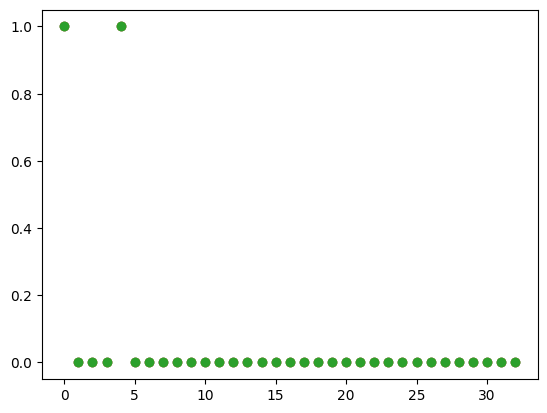

In [135]:
X0,Y0,Z0 =Evaluate_Features(qc3,3,2,3,np.zeros([3,2]),np.zeros([5]))
plt.scatter(range(len(X0)),X0)
plt.scatter(range(len(X0)),Y0)
plt.scatter(range(len(X0)),Z0)

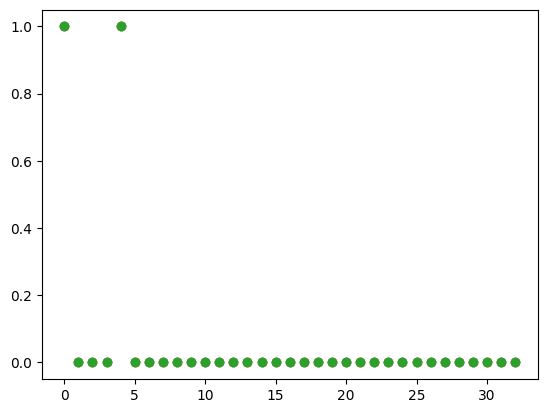

In [138]:
phi2=np.array([[np.pi*0.8,0],[np.pi*0.8,0],[np.pi*0.8,0]])
theta2=np.array([2.84,-4.5,9.08,9.57,6.37])
X0,Y0,Z0 =Evaluate_Features(qc3,3,2,3,phi2,theta2)
plt.scatter(range(len(X0)),X0)
plt.scatter(range(len(X0)),Y0)
plt.scatter(range(len(X0)),Z0)

In [140]:
XEV=[]
YEV=[]
ZEV=[]
for i in np.linspace(0,1,101):
    phi2=np.array([[np.pi*0.8,i],[np.pi*0.8,i],[np.pi*0.8,i]])
    theta2=np.array([2.84,-4.5,9.08,9.57,6.37])
    X0,Y0,Z0 =Evaluate_Features(qc3,3,2,3,phi2,theta2)
    XEV.append(X0)
    YEV.append(Y0)
    ZEV.append(Z0)

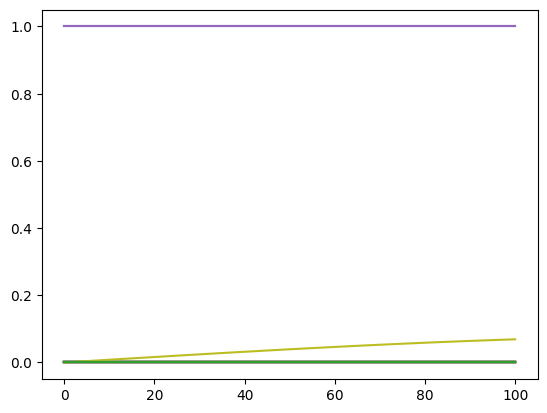

In [141]:
plt.plot(XEV)

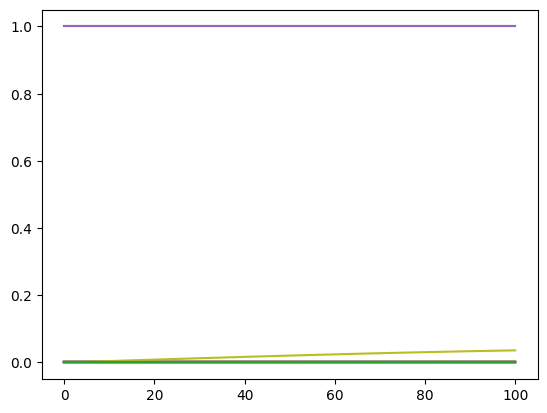

In [142]:
plt.plot(YEV)

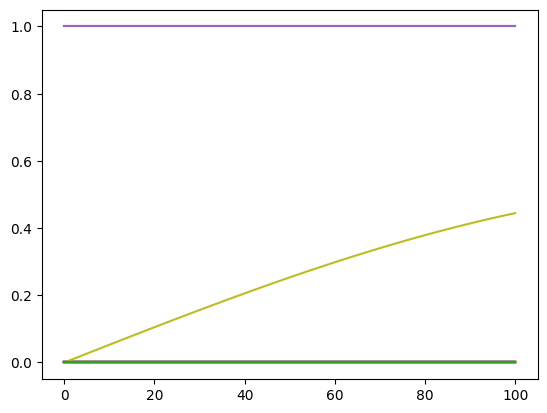

In [143]:
plt.plot(ZEV)

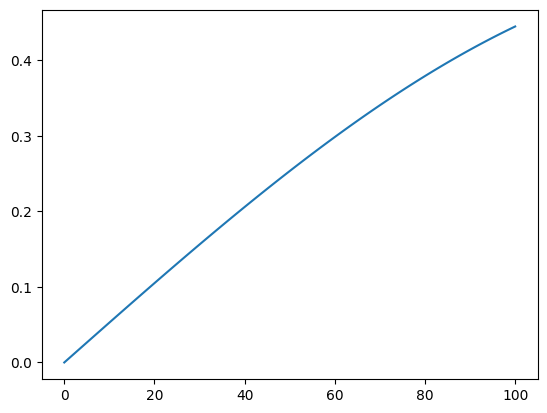

In [162]:
plt.plot(np.array(ZEV)[:,28:29])

In [179]:
[qc2,Meas2] = Simulated_Reservoir(2)
XEV=[]
YEV=[]
ZEV=[]
for i in np.linspace(0,1,101):
    phi2=np.array([[np.pi*0.8,i],[np.pi*0.8,i]])
    theta2=np.array([2.84,-4.5,9.08,9.57,6.37])
    X0,Y0,Z0 =Evaluate_Features(qc2,3,2,2,phi2,theta2)
    XEV.append(X0)
    YEV.append(Y0)
    ZEV.append(Z0)

[[0, 1, 2, 3, 4], [0, 1, 2, 5, 6]]


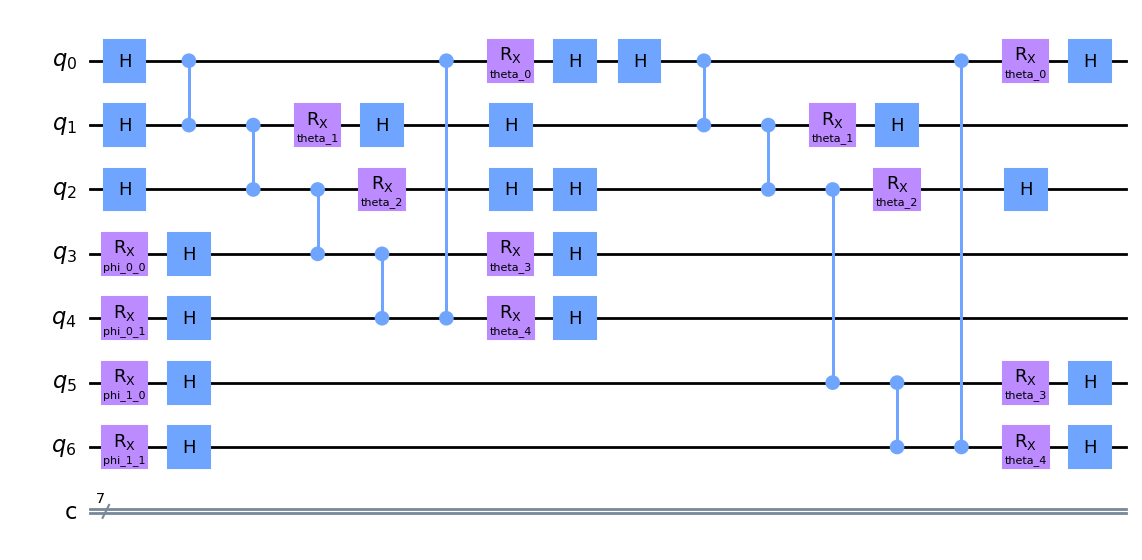

In [183]:
qc2.draw('mpl')

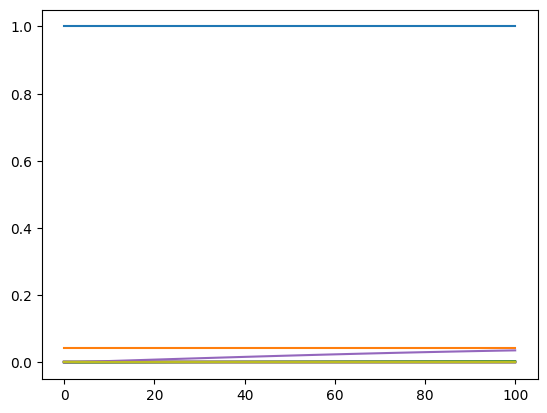

In [182]:
plt.plot(YEV)

In [171]:
len(XEV)

101

In [270]:
['IIIIIII', 'IIIIZII', 'IIIZIII', 'IIIZZII', 'IIIIII', 'IIIIZI', 'IIIZII', 'IIIZZI', 'IIIIIIIIZ', 'IIZIIIIII', 'ZIIIIIIII', 'IIIIIIIZI', 'IZIIIIIII', 'ZIZIIIIII', 'ZZIIIIIII', 'IIZIIIIIZ', 'ZIIIIIIIZ', 'IZIIIIIZI', 'IZIIIIIIZ', 'IZZIIIIII', 'IIIIIIIZZ', 'IIZIIIIZI', 'ZIIIIIIZI', 'IIZIIIIZZ', 'ZIIIIIIZZ', 'IZZIIIIIZ', 'ZIZIIIIZI', 'IZIIIIIZZ', 'ZZIIIIIZI', 'ZZIIIIIIZ', 'ZZZIIIIII', 'IZZIIIIZI', 'ZIZIIIIIZ'][24]

'ZIIIIIIZZ'

In [256]:
[qc3,Meas3] = Simulated_Reservoir(3)
XEV=[]
YEV=[]
ZEV=[]
for i in np.linspace(0,1,101):
    phi2=np.array([[np.pi*0.8,i],[np.pi*0.8,i],[np.pi*0.8,i]])
    theta2=np.array([2.84,-4.5,9.08,9.57,6.37])
    X0,Y0,Z0,ev =Evaluate_Features(qc3,3,2,3,phi2,theta2)
    XEV.append(X0)
    YEV.append(Y0)
    ZEV.append(Z0)

[[0, 1, 2, 3, 4], [0, 1, 2, 5, 6], [0, 1, 2, 7, 8]]


In [278]:
pure=np.dot(np.array([[1,1,1,-1]]).T/2,np.array([[1,1,1,-1]])/2)
print(np.linalg.eig(pure))
pure=pure.reshape([2,2,2,2])
pure=pure.transpose([0,3,2,1])
pure=pure.reshape(4,4)
np.linalg.eig(pure)

(array([0., 1., 0., 0.]), array([[-8.66025404e-01,  5.00000000e-01, -2.77555756e-17,
         2.77555756e-17],
       [ 2.88675135e-01,  5.00000000e-01, -5.77350269e-01,
         5.77350269e-01],
       [ 2.88675135e-01,  5.00000000e-01,  7.88675135e-01,
         2.11324865e-01],
       [-2.88675135e-01, -5.00000000e-01,  2.11324865e-01,
         7.88675135e-01]]))


(array([ 0.5, -0.5,  0.5,  0.5]),
 array([[ 0.8660254 ,  0.5       , -0.3528287 , -0.25586923],
        [ 0.28867513, -0.5       , -0.85253215, -0.31153791],
        [ 0.28867513, -0.5       ,  0.35905128, -0.61866607],
        [ 0.28867513, -0.5       ,  0.14065217,  0.67433476]]))

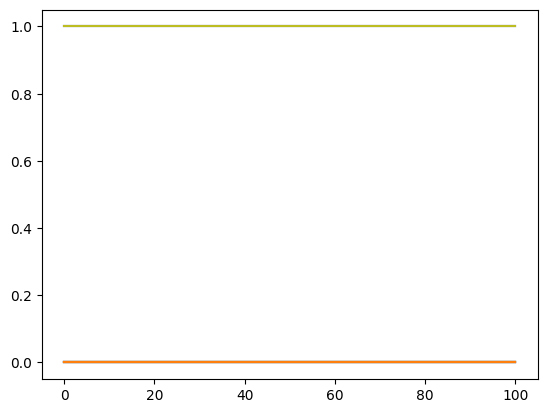

In [259]:
plt.plot(np.array(ZEV)[:,0:4])
plt.plot(np.array(XEV)[:,0:4])
plt.plot(np.array(YEV)[:,0:4])

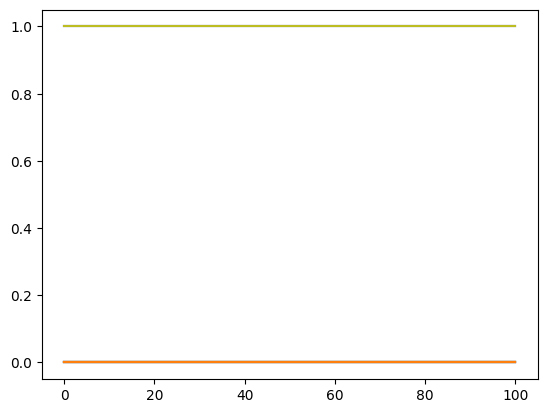

In [260]:
plt.plot(np.array(ZEV)[:,4:8])
plt.plot(np.array(XEV)[:,4:8])
plt.plot(np.array(YEV)[:,4:8])

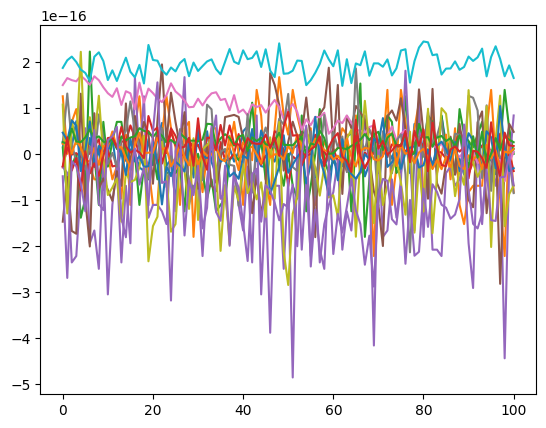

In [261]:
plt.plot(np.array(ZEV)[:,8:13])
plt.plot(np.array(XEV)[:,8:13])
plt.plot(np.array(YEV)[:,8:13])

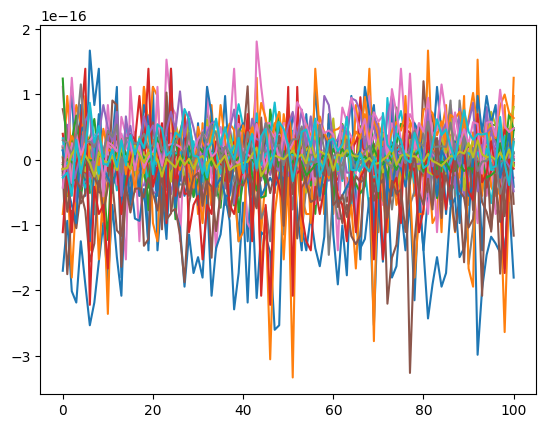

In [262]:
plt.plot(np.array(ZEV)[:,13:23])
plt.plot(np.array(XEV)[:,13:23])
plt.plot(np.array(YEV)[:,13:23])

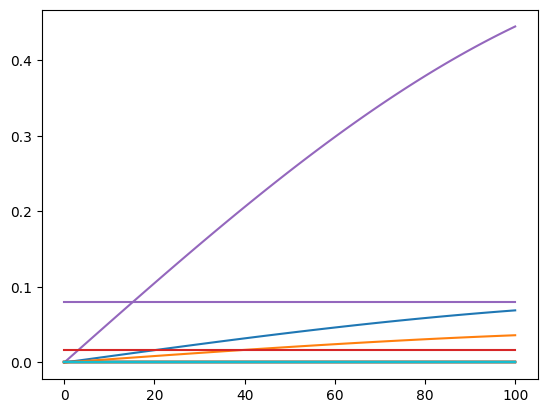

In [264]:
plt.plot(np.array(ZEV)[:,23:33])
plt.plot(np.array(XEV)[:,23:33])
plt.plot(np.array(YEV)[:,23:33])

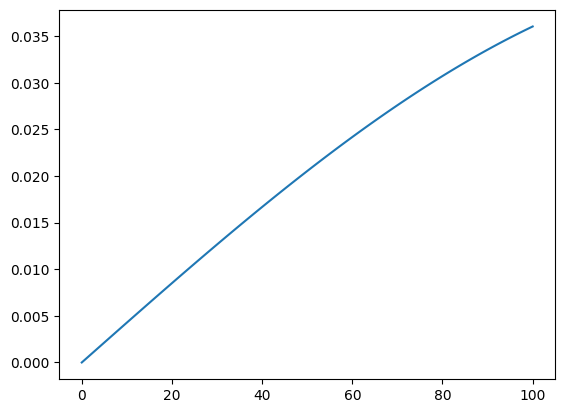

In [268]:
#plt.plot(np.array(ZEV)[:,24])
#plt.plot(np.array(XEV)[:,24])
plt.plot(np.array(YEV)[:,24])

In [222]:
['IIIIIII', 'IIIIZII', 'IIIZIII', 'IIIZZII', 'IIIIII', 'IIIIZI', 'IIIZII', 'IIIZZI', 'IIIIIIIIZ', 'IIZIIIIII', 'ZIIIIIIII', 'IIIIIIIZI', 'IZIIIIIII', 'ZIZIIIIII', 'ZZIIIIIII', 'IIZIIIIIZ', 'ZIIIIIIIZ', 'IZIIIIIZI', 'IZIIIIIIZ', 'IZZIIIIII', 'IIIIIIIZZ', 'IIZIIIIZI', 'ZIIIIIIZI', 'IIZIIIIZZ', 'ZIIIIIIZZ', 'IZZIIIIIZ', 'ZIZIIIIZI', 'IZIIIIIZZ', 'ZZIIIIIZI', 'ZZIIIIIIZ', 'ZZZIIIIII', 'IZZIIIIZI', 'ZIZIIIIIZ'][14]

'ZZIIIIIII'

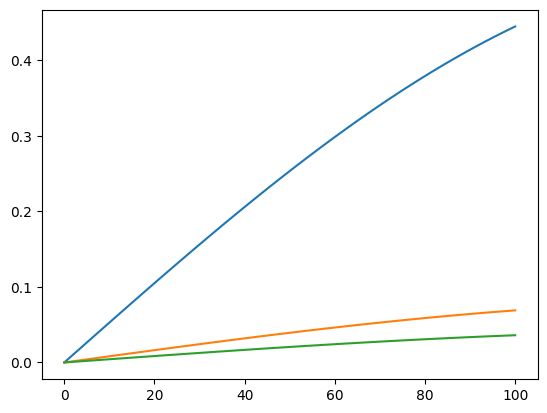

In [205]:
plt.plot(np.array(ZEV)[:,28])
plt.plot(np.array(XEV)[:,28])
plt.plot(np.array(YEV)[:,28])

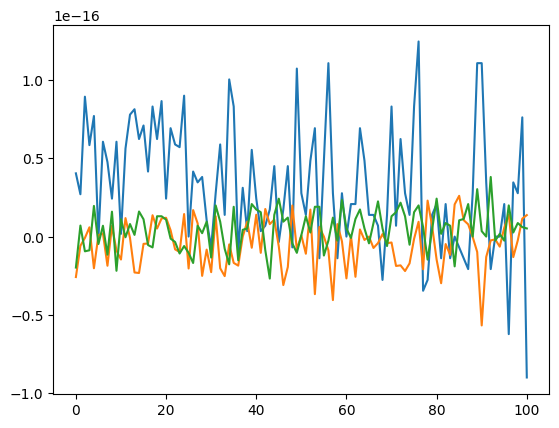

In [206]:
plt.plot(np.array(ZEV)[:,29])
plt.plot(np.array(XEV)[:,29])
plt.plot(np.array(YEV)[:,29])

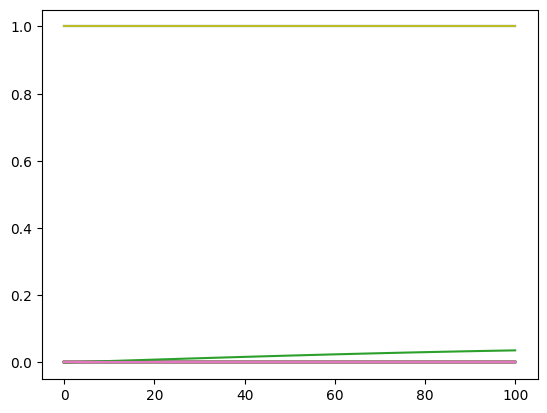

In [187]:
plt.plot(YEV)

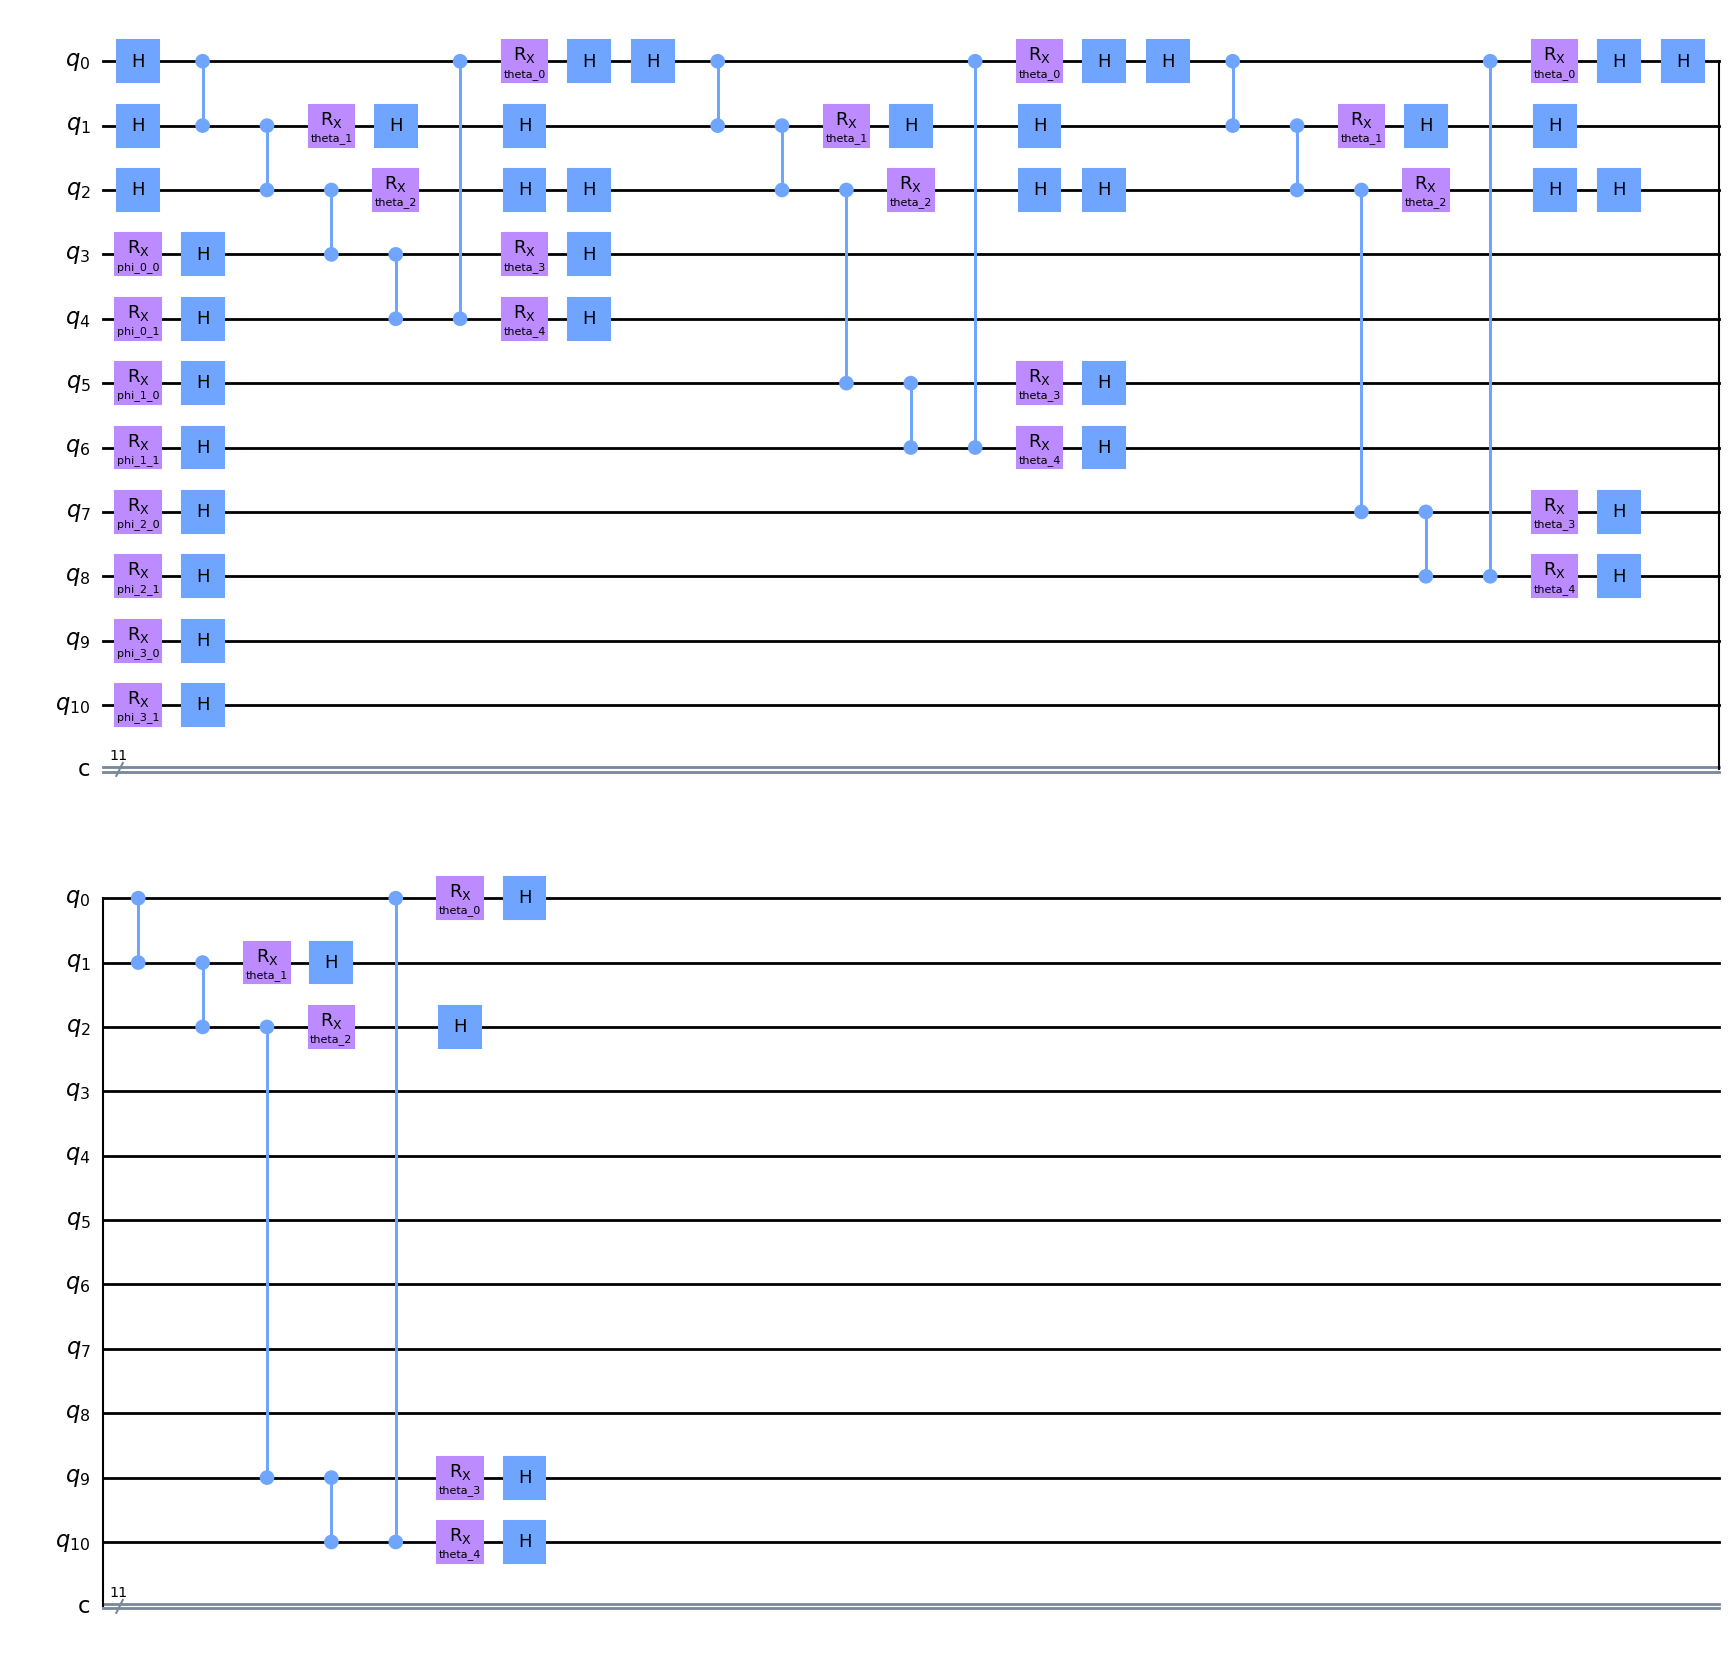

In [188]:
qc4.draw('mpl')

In [230]:
phi2=np.array([[np.pi*0.8,0.7],[np.pi*0.8,0.7],[np.pi*0.8,0.7]])
theta2=np.array([2.84,-4.5,9.08,9.57,6.37])
X0,Y0,Z0,ev =Evaluate_Features(qc3,3,2,3,phi2,theta2)

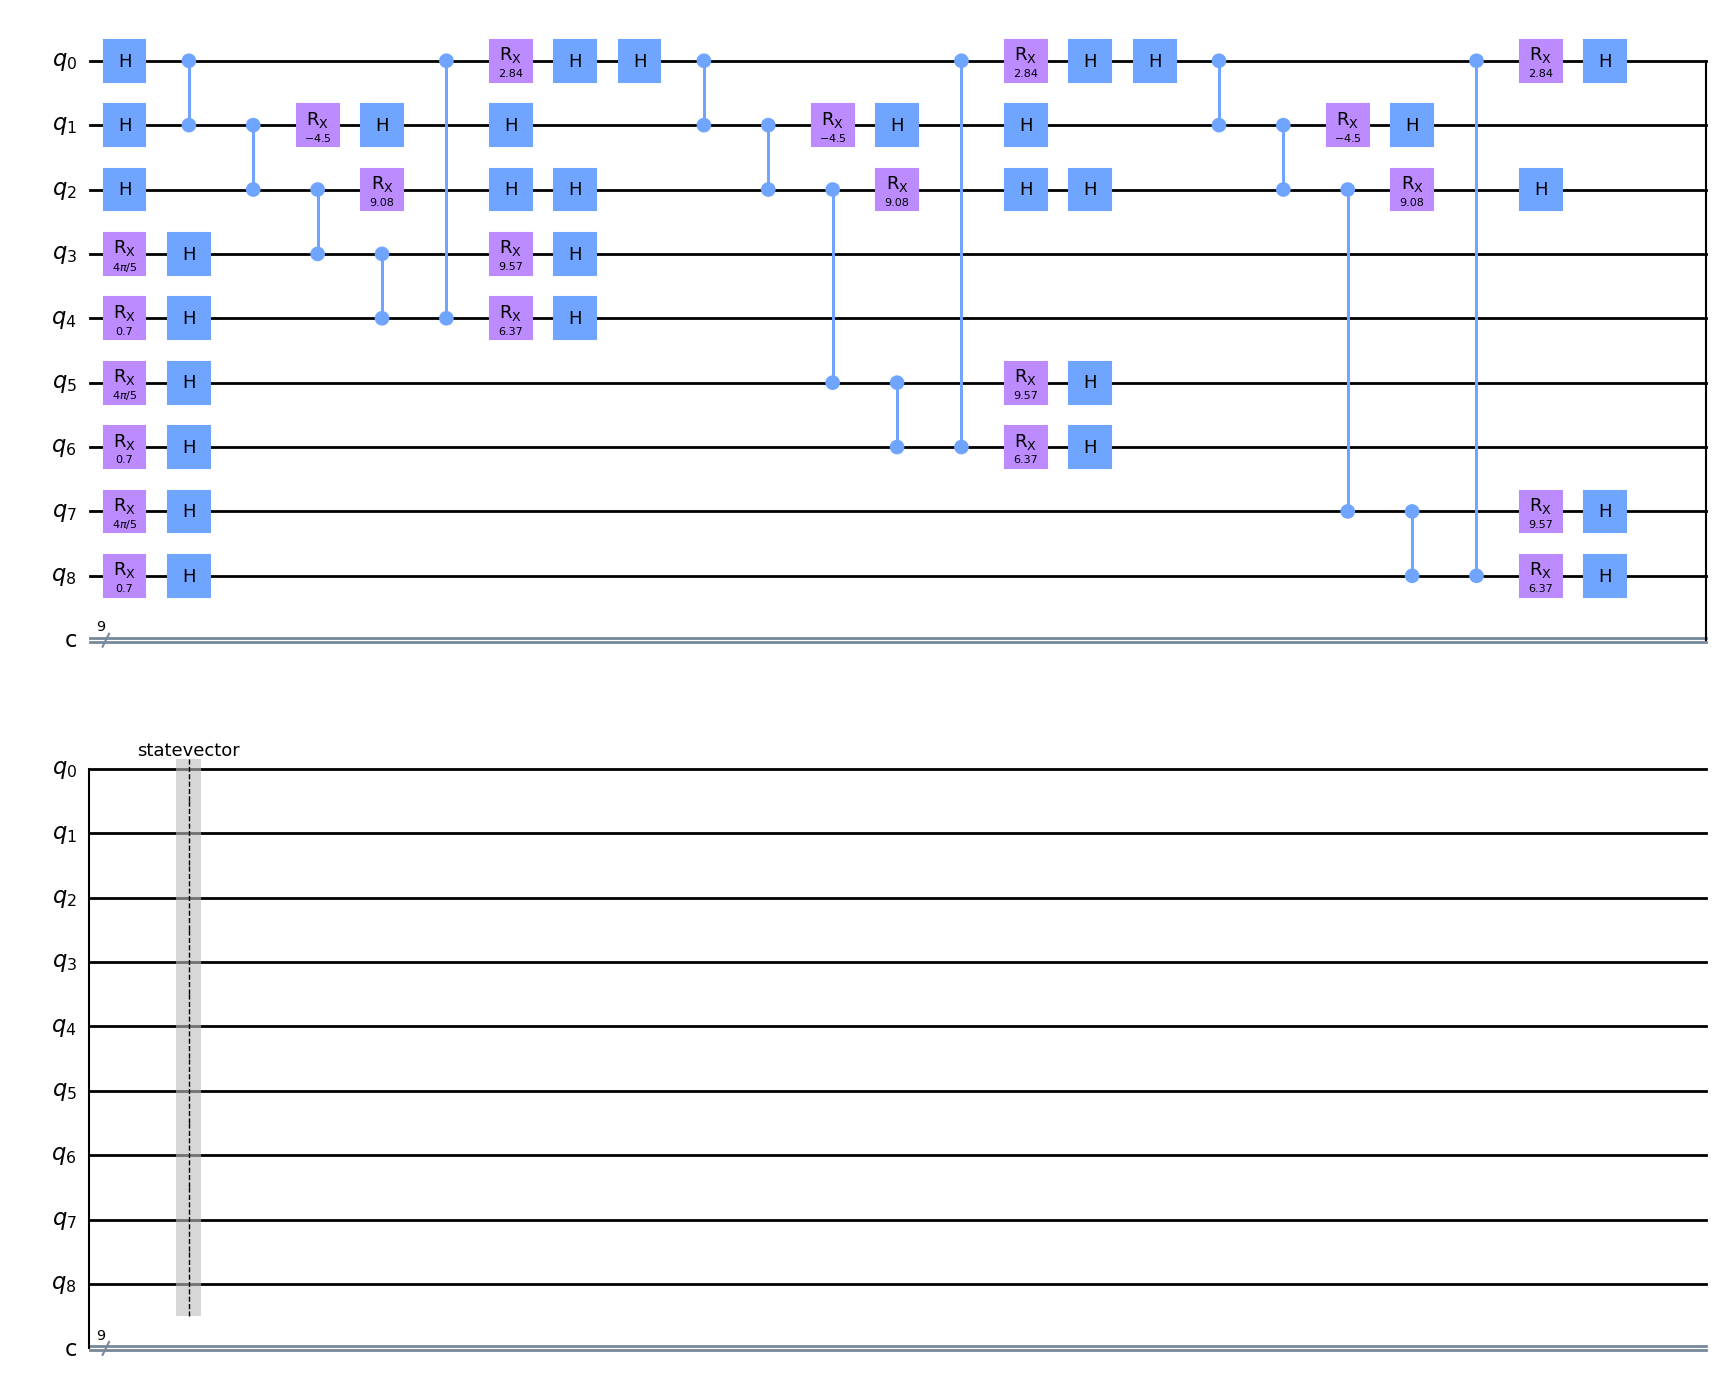

In [231]:
ev.draw('mpl')

In [239]:
test=QuantumCircuit(1,1)
test.rx(0.7,0)
test.h(0)
test.rx(6.37,0)
test.h(0)
test.save_statevector()
backend = AerSimulator(method='statevector')
job = execute(test, backend=backend, shots=1, memory=True)
job_result = job.result()
sv=job_result.get_statevector(test)

In [246]:
sv.expectation_value(Pauli('Z'))

0.7648421872844886

In [250]:
test=QuantumCircuit(2,0)
test.rx(0.7,0)
test.h(0)
test.rx(6.37,0)
test.h(0)
test.x(1)
test.save_statevector()
backend = AerSimulator(method='statevector')
job = execute(test, backend=backend, shots=1, memory=True)
job_result = job.result()
sv=job_result.get_statevector(test)
sv.expectation_value(Pauli('ZI'))


-1.0

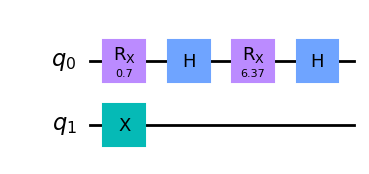

In [248]:
test.draw('mpl')

In [280]:
hmat=np.array([[1,1],[1,-1]])/np.sqrt(2)
cz=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,-1]])

In [281]:
np.dot(np.dot(np.dot(np.kron(hmat,hmat),cz),np.kron(hmat,hmat)),np.array([[1],[0],[0],[0]]))

array([[ 0.5],
       [ 0.5],
       [ 0.5],
       [-0.5]])

In [286]:
QOp=QuantumCircuit(5,0)
QOp.cz(0,1)
QOp.cz(1,2)
QOp.cz(2,3)
QOp.cz(3,4)
QOp.cz(4,0)

In [290]:
from qiskit.quantum_info import SuperOp
from qiskit.quantum_info import Kraus

In [289]:
SuperOp(QOp)

SuperOp([[1.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 1.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 1.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
         ...,
         [0.+0.j, 0.+0.j, 0.+0.j, ..., 1.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 1.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 1.+0.j]],
        input_dims=(2, 2, 2, 2, 2), output_dims=(2, 2, 2, 2, 2))

In [292]:
Kraus(SuperOp,input_dims=(2),output_dims=(2))

TypeError: QuantumChannel.to_operator() missing 1 required positional argument: 'self'

In [303]:
[qc1,Meas1] = Simulated_Reservoir(1,'x')
XEV=[]
YEV=[]
ZEV=[]
for i in np.linspace(0,1,101):
    phi2=np.array([[np.pi*0.8,i]])
    theta2=np.array([2.84,-4.5,9.08,9.57,6.37])
    X0,Y0,Z0,ev =Evaluate_Features(qc1,3,2,1,phi2,theta2)
    XEV.append(X0)
    YEV.append(Y0)
    ZEV.append(Z0)

[[0, 1, 2, 3, 4]]


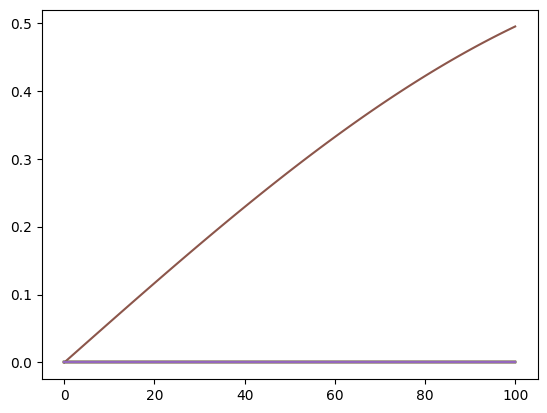

In [304]:
plt.plot(ZEV)

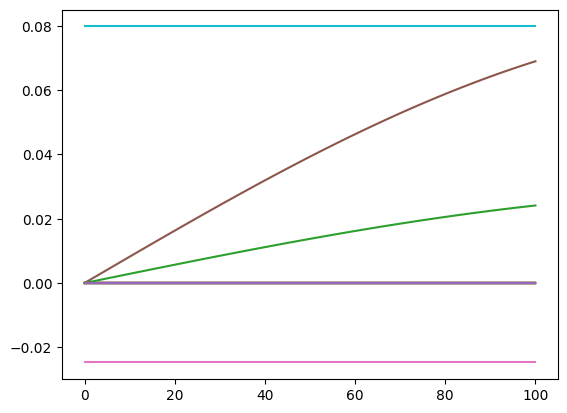

In [295]:
plt.plot(XEV)

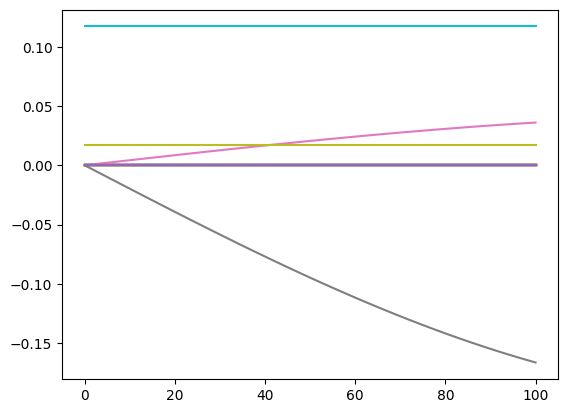

In [296]:
plt.plot(YEV)

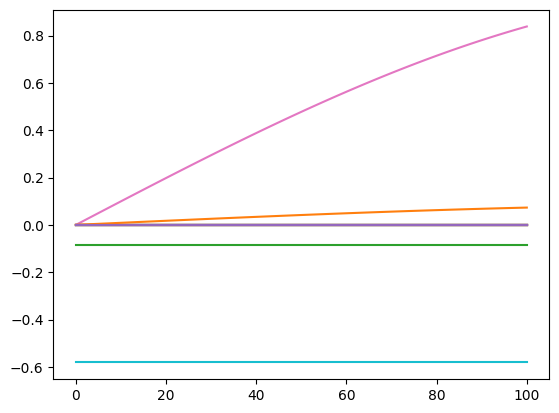

In [305]:
plt.plot(np.array(ZEV)[:,0:5])
plt.plot(np.array(XEV)[:,0:5])
plt.plot(np.array(YEV)[:,0:5])

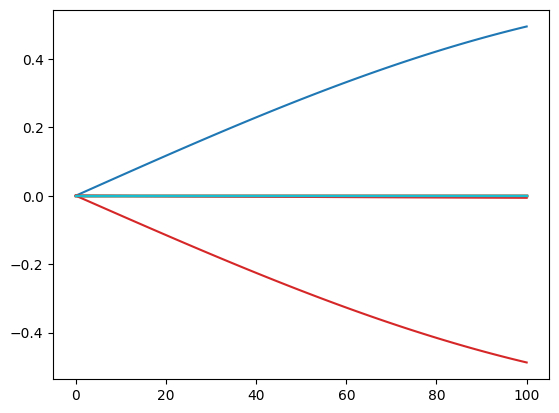

In [306]:
plt.plot(np.array(ZEV)[:,5:15])
plt.plot(np.array(XEV)[:,5:15])
plt.plot(np.array(YEV)[:,5:15])

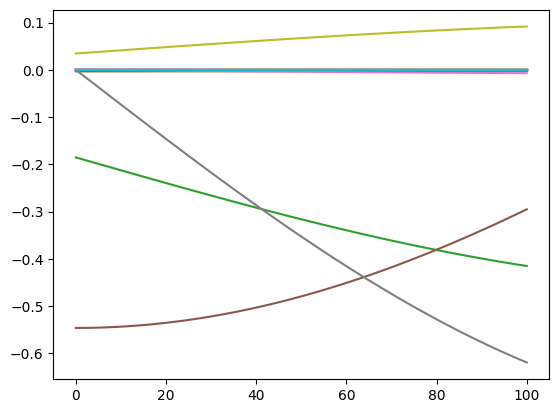

In [307]:
plt.plot(np.array(ZEV)[:,15:25])
plt.plot(np.array(XEV)[:,15:25])
plt.plot(np.array(YEV)[:,15:25])

In [309]:
[qc2,Meas2] = Simulated_Reservoir(2)
XEV=[]
YEV=[]
ZEV=[]
for i in np.linspace(0,1,101):
    phi2=np.array([[np.pi*0.8,i],[np.pi*0.8,i]])
    theta2=np.array([2.84,-4.5,9.08,9.57,6.37])
    X0,Y0,Z0,ev =Evaluate_Features(qc2,3,2,2,phi2,theta2)
    XEV.append(X0)
    YEV.append(Y0)
    ZEV.append(Z0)

[[0, 1, 2, 3, 4], [0, 1, 2, 5, 6]]


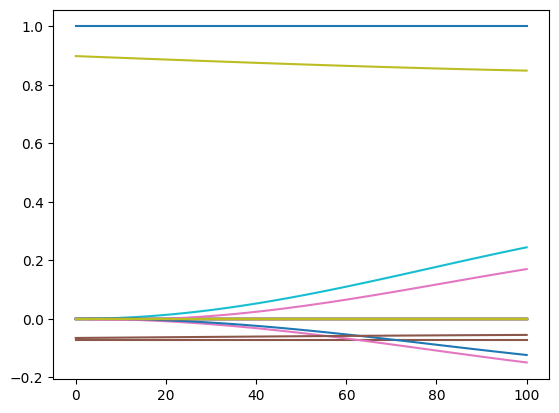

In [314]:
plt.plot(ZEV)

In [456]:
def Simulated_Transpiled_Reservoir(nsteps_in,enc):
    
    Meas_List=[] # we need to keep this for set-up of the final circuits.

    # We produce a custom version of the "manual constuction".
    Manual_Layout_List=[]
    nmem = 3
    nsteps=nsteps_in
    for step in range(nsteps):
        memory_qubits=list(range(nmem))
        data_qubits=list(range(nmem+step*2,nmem+(step+1)*2))
        Manual_Layout_List+= [memory_qubits + data_qubits]
    print(Manual_Layout_List)
    if max(Manual_Layout_List[-1])>nmem+2*nsteps:
        print('warning: circuit too large for backend!')
        qc = QuantumCircuit(Manual_Layout_List[-1],Manual_Layout_List[-1])
    else:
    #Overall circuit!
        qc = QuantumCircuit(20, nmem+2*nsteps)

    #And the current circuit.
    c_circuit = QuantumCircuit(5,2)



        

    #Manually create a swap:
    cSWAP=QuantumCircuit(2,0)
    cSWAP.swap(0,1)
    #gSWAP=transpile(cSWAP, basis_gates=['r', 'cz'], optimization_level = 0)

    #For the automatic circuits, we use the qiskit gates and allow transpilation.

        

    theta_list=[Parameter('theta_'+str(i)) for i in range(len(Manual_Layout_List[0]))]
    for step in range(nsteps): # Loop over all steps used..:
        c_qubits=Manual_Layout_List[step]
        # Add undefined inputs:
        qn = 0 # qubit counter for loop
        for c in range(1):
            for d in range(int(2 /1)): # dimx
                phi_c = Parameter('phi_'+str(step)+'_'+str(qn))
                
                #print(step,qn,c_qubits[self.memory_size+0*self.dimxqc+self.qin[qn]])
                if True:
                    match enc:
                        case 'x':
                            qc.rx(theta=phi_c,qubit=c_qubits[3+[0,1][qn]])
                        case 'y':
                            qc.ry(theta=phi_c, qubit=c_qubits[3+[0,1][qn]])
                        case 'z':
                            qc.rz(phi=phi_c, qubit=c_qubits[3+[0,1][qn]])
                        case _:
                            raise Warning(f'Invalid encaxes={self.encaxes}')
                elif False: 
                    self.encaxes = ['ry', 'rz']
                    qc.h(qubit=self.memory_size+0*self.dimxqc+self.qin[qn])
                    qc.ry(np.arctan(phi_c) + np.pi/4, qubit=self.memory_size+step*self.dimxqc+self.qin[qn])
                    qc.rz(np.arctan(phi_c**2) + np.pi/4, qubit=self.memory_size+step*self.dimxqc+self.qin[qn])

                    
                else:
                    raise Warning(f'Invalid enctype {self.enctype}')
                qn += 1
            
                

            
        for i in range(len(c_qubits)):
            #H
            qc.h(qubit=c_qubits[i])
            #qc.r(theta=np.pi,phi=0, qubit=c_qubits[i])



        # CZ
        for i in range(len(c_qubits)-1):
            qc.cz(control_qubit=c_qubits[i],target_qubit=c_qubits[i+1])
        qc.cz(control_qubit=c_qubits[-1],target_qubit=c_qubits[0])

        #XROT
        for i in range(len(c_qubits)):
            #X
            
            qc.rx(theta=theta_list[i],qubit=c_qubits[i])
            #H
            qc.h(qubit=c_qubits[i])
            #qc.r(theta=np.pi,phi=0, qubit=c_qubits[i])

            

            




        #We will keep track of which measurements to perform here:
        if 2 > 0:
            adj_meas=[k + 3 for k in [0,1]]
            
            Meas_List  += [[Manual_Layout_List[step][k] for k in adj_meas]]

    #In the last step, we measure ALL qubits.
    Meas_List[-1]=Manual_Layout_List[-1]

    #We now have to transpile the circuit!
    ## define the circuit to be run on the hardware
    #opt_level = self.opt_level ## defines the optimization level


    #Not necessary...

    #if (self.QPU == 'Apollo'):
    #    qubit_names = ["QB3", "QB8", "QB4", "QB9", "QB13", "QB14", "QB5", "QB10", "QB15", "QB6", "QB11", "QB16", "QB7", "QB12", "QB17", "QB18", "QB19", "QB20", "QB1", "QB2"]
    #elif (self.QPU == 'Adonis'):
    #    qubit_names = ["QB1", "QB3", "QB2", "QB4", "QB5"]

    # We allow qiskit to perform transpilation!
    tqc = transpile(qc,backend=IQMbackend,optimization_level=3)
    # We need to see how the qubits have been permuted:
    perm_lib_qiskit=tqc.layout.initial_layout
    # This is the wrong form for our purposes: we need to swap it:

    
    meas_mapping={perm_lib_qiskit[k].index:k for k in range(20)}

    Meas_List=[[meas_mapping[i] for i in k] for k in Meas_List]

    return tqc, Meas_List


In [337]:
[tqc1,tMeas1] = Simulated_Transpiled_Reservoir(1,'y')


[[0, 1, 2, 3, 4]]


/tmp/ipykernel_1463769/2778848846.py:127: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  meas_mapping={perm_lib_qiskit[k].index:k for k in range(20)}


In [346]:
def replacer(s, newstring, indices, nofail=False):
    # raise an error if index is outside of the string


    for i in range(len(indices)):
        s = s[:indices[i]] + newstring[i] + s[indices[i] + 1:]

    # insert the new string between "slices" of the original
    return s

In [347]:
replacer('I'*20,'XYZ',[6,7,19])

'IIIIIIXYIIIIIIIIIIIZ'

In [1]:
def Evaluate_Transpiled_Features(qc,tMeas,nmem,nin,nsteps,phi,theta):
    param_map={k.name:k for k in qc.parameters}
    shape_phi=phi.shape
    phi_assignment={param_map['phi_%s_%s' % (k,s)]:phi[k,s] for k in range(shape_phi[0]) for s in range(shape_phi[1])}
    theta_assignment={param_map['theta_%s' % k]:theta[k] for k in range(len(theta))}
    explicit_val=qc.assign_parameters(phi_assignment)
    explicit_val=explicit_val.assign_parameters(theta_assignment)
    explicit_val.save_statevector()
    backend = AerSimulator(method='statevector')
    job = execute(explicit_val, backend=backend, shots=1, memory=True)
    job_result = job.result()
    sv=job_result.get_statevector(explicit_val)

    #Need expectation values!
    nqubits=len(qc.qubits)
    XL = []
    YL = []
    ZL = []
    partialX=list(''.join(k) for k in product('IX',repeat=nin))
    partialY=list(''.join(k) for k in product('IY',repeat=nin))
    partialZ=list(''.join(k) for k in product('IZ',repeat=nin))
    for i in range(nsteps-1):
        TotalExp='I'*20
        XL += [replacer(TotalExp,k,tMeas[i]) for k  in partialX ]
        YL += [replacer(TotalExp,k,tMeas[i]) for k  in partialY ]
        ZL += [replacer(TotalExp,k,tMeas[i]) for k  in partialZ ]
    
    
    #Now add manually the final measurements:
    fbody=3
    original_meas_x=['I'*(nmem+nin-fcurr)+'X'*fcurr for fcurr in range(1,fbody+1)]
    original_meas_y=['I'*(nmem+nin-fcurr)+'Y'*fcurr for fcurr in range(1,fbody+1)]
    original_meas_z=['I'*(nmem+nin-fcurr)+'Z'*fcurr for fcurr in range(1,fbody+1)]
    for fcurr in range(fbody):
        xstrings=list(set(list(''.join(k) for k in permutations(original_meas_x[fcurr], nmem+nin))))
        xfinal=[replacer(TotalExp,k,tMeas[-1]) for k in xstrings]
        XL += xfinal
        ystrings=list(set(list(''.join(k) for k in permutations(original_meas_y[fcurr], nmem+nin))))
        yfinal=[replacer(TotalExp,k,tMeas[-1]) for k in ystrings]
        YL += yfinal
        zstrings=list(set(list(''.join(k) for k in permutations(original_meas_z[fcurr], nmem+nin))))
        zfinal=[replacer(TotalExp,k,tMeas[-1])+k[nmem:] for k in zstrings]
        ZL += zfinal
    
    #use [::-1] as Qiskit opposite of what I think!
    X = [sv.expectation_value(Pauli(k[::-1])) for k in XL]
    Y = [sv.expectation_value(Pauli(k[::-1])) for k in YL]
    Z = [sv.expectation_value(Pauli(k[::-1])) for k in ZL]

    return X,Y,Z,explicit_val,sv,ZL

In [411]:
[tqc2,tMeas2] = Simulated_Transpiled_Reservoir(2,'y')
XEV=[]
YEV=[]
ZEV=[]
for i in np.linspace(0,1,101):
    phi2=np.array([[np.pi*0.8,i],[np.pi*0.8,i]])
    theta2=np.array([2.84,-4.5,9.08,9.57,6.37])
    X0,Y0,Z0,ev =Evaluate_Transpiled_Features(tqc2,tMeas2,3,2,2,phi2,theta2)
    XEV.append(X0)
    YEV.append(Y0)
    ZEV.append(Z0)

[[0, 1, 2, 3, 4], [0, 1, 2, 5, 6]]
['IIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIZIIIZ', 'IIIIIZIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIZIIIIIIIIIII', 'IIIIIIZIIIIIIIIIIIIIZI', 'IIIIIIIIIIIZIIIIIIIIII', 'IIIIIIIIIIZIIIIIZIIIII', 'IIIIIIIIIIZZIIIIIIIIII', 'IIIIIZIIIIIIIIIIZIIIIZ', 'IIIIIZIIIIZIIIIIIIIIIZ', 'IIIIIIZIIIIZIIIIIIIIZI', 'IIIIIZIIIIIZIIIIIIIIIZ', 'IIIIIIIIIIIZIIIIZIIIII', 'IIIIIZZIIIIIIIIIIIIIZZ', 'IIIIIIZIIIIIIIIIZIIIZI', 'IIIIIIZIIIZIIIIIIIIIZI', 'IIIIIZZIIIIIIIIIZIIIZZ', 'IIIIIZZIIIZIIIIIIIIIZZ', 'IIIIIZIIIIIZIIIIZIIIIZ', 'IIIIIIZIIIZIIIIIZIIIZI', 'IIIIIZZIIIIZIIIIIIIIZZ', 'IIIIIIZIIIZZIIIIIIIIZI', 'IIIIIZIIIIZZIIIIIIIIIZ', 'IIIIIIIIIIZZIIIIZIIIII', 'IIIIIIZIIIIZIIIIZIIIZI', 'IIIIIZIIIIZIIIIIZIIIIZ']


/tmp/ipykernel_1463769/16163771.py:127: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  meas_mapping={perm_lib_qiskit[k].index:k for k in range(20)}


['IIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIZIIIZ', 'IIIIIZIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIZIIIIIIIIIII', 'IIIIIIZIIIIIIIIIIIIIZI', 'IIIIIIIIIIIZIIIIIIIIII', 'IIIIIIIIIIZIIIIIZIIIII', 'IIIIIIIIIIZZIIIIIIIIII', 'IIIIIZIIIIIIIIIIZIIIIZ', 'IIIIIZIIIIZIIIIIIIIIIZ', 'IIIIIIZIIIIZIIIIIIIIZI', 'IIIIIZIIIIIZIIIIIIIIIZ', 'IIIIIIIIIIIZIIIIZIIIII', 'IIIIIZZIIIIIIIIIIIIIZZ', 'IIIIIIZIIIIIIIIIZIIIZI', 'IIIIIIZIIIZIIIIIIIIIZI', 'IIIIIZZIIIIIIIIIZIIIZZ', 'IIIIIZZIIIZIIIIIIIIIZZ', 'IIIIIZIIIIIZIIIIZIIIIZ', 'IIIIIIZIIIZIIIIIZIIIZI', 'IIIIIZZIIIIZIIIIIIIIZZ', 'IIIIIIZIIIZZIIIIIIIIZI', 'IIIIIZIIIIZZIIIIIIIIIZ', 'IIIIIIIIIIZZIIIIZIIIII', 'IIIIIIZIIIIZIIIIZIIIZI', 'IIIIIZIIIIZIIIIIZIIIIZ']
['IIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIZIIIZ', 'IIIIIZIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIZIIIIIIIIIII', 'IIIIIIZIIIIIIIIIIIIIZI', 'IIIIIIIIIIIZIIIIIIIIII', 'IIIIIIIIIIZIIIIIZIIIII', 

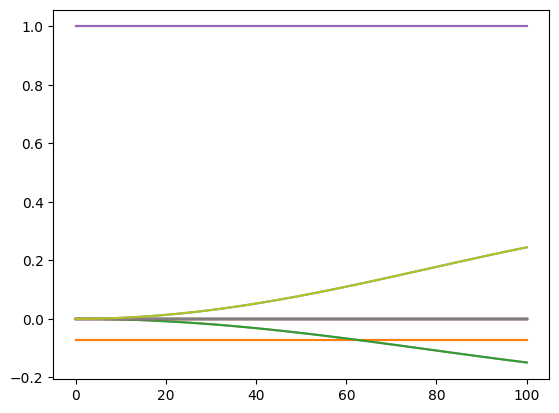

In [363]:
plt.plot(ZEV)

In [369]:
[qc2,Meas2] = Simulated_Reservoir(2,'y')
XEVS=[]
YEVS=[]
ZEVS=[]
for i in np.linspace(0,1,101):
    phi2=np.array([[np.pi*0.8,i],[np.pi*0.8,i]])
    theta2=np.array([2.84,-4.5,9.08,9.57,6.37])
    X0,Y0,Z0,ev =Evaluate_Features(qc2,3,2,2,phi2,theta2)
    XEVS.append(X0)
    YEVS.append(Y0)
    ZEVS.append(Z0)

[[0, 1, 2, 3, 4], [0, 1, 2, 5, 6]]


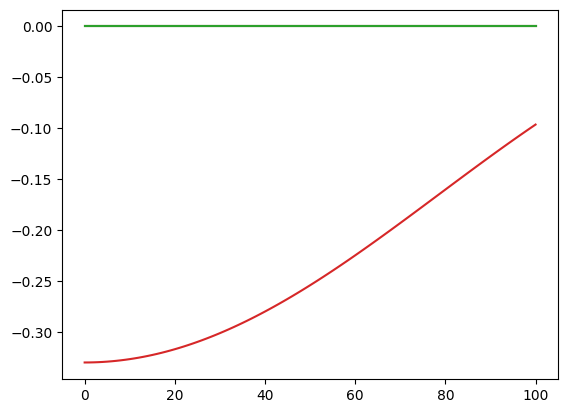

In [386]:
plt.plot(np.array(ZEV)[:,0:4]-np.array(ZEVS)[:,0:4])

In [381]:
[tqc2_space,tMeas2_space] = Simulated_Transpiled_Reservoir(2,'y')

[[0, 1, 2, 3, 4], [0, 1, 2, 5, 6]]


/tmp/ipykernel_1463769/16163771.py:127: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  meas_mapping={perm_lib_qiskit[k].index:k for k in range(20)}


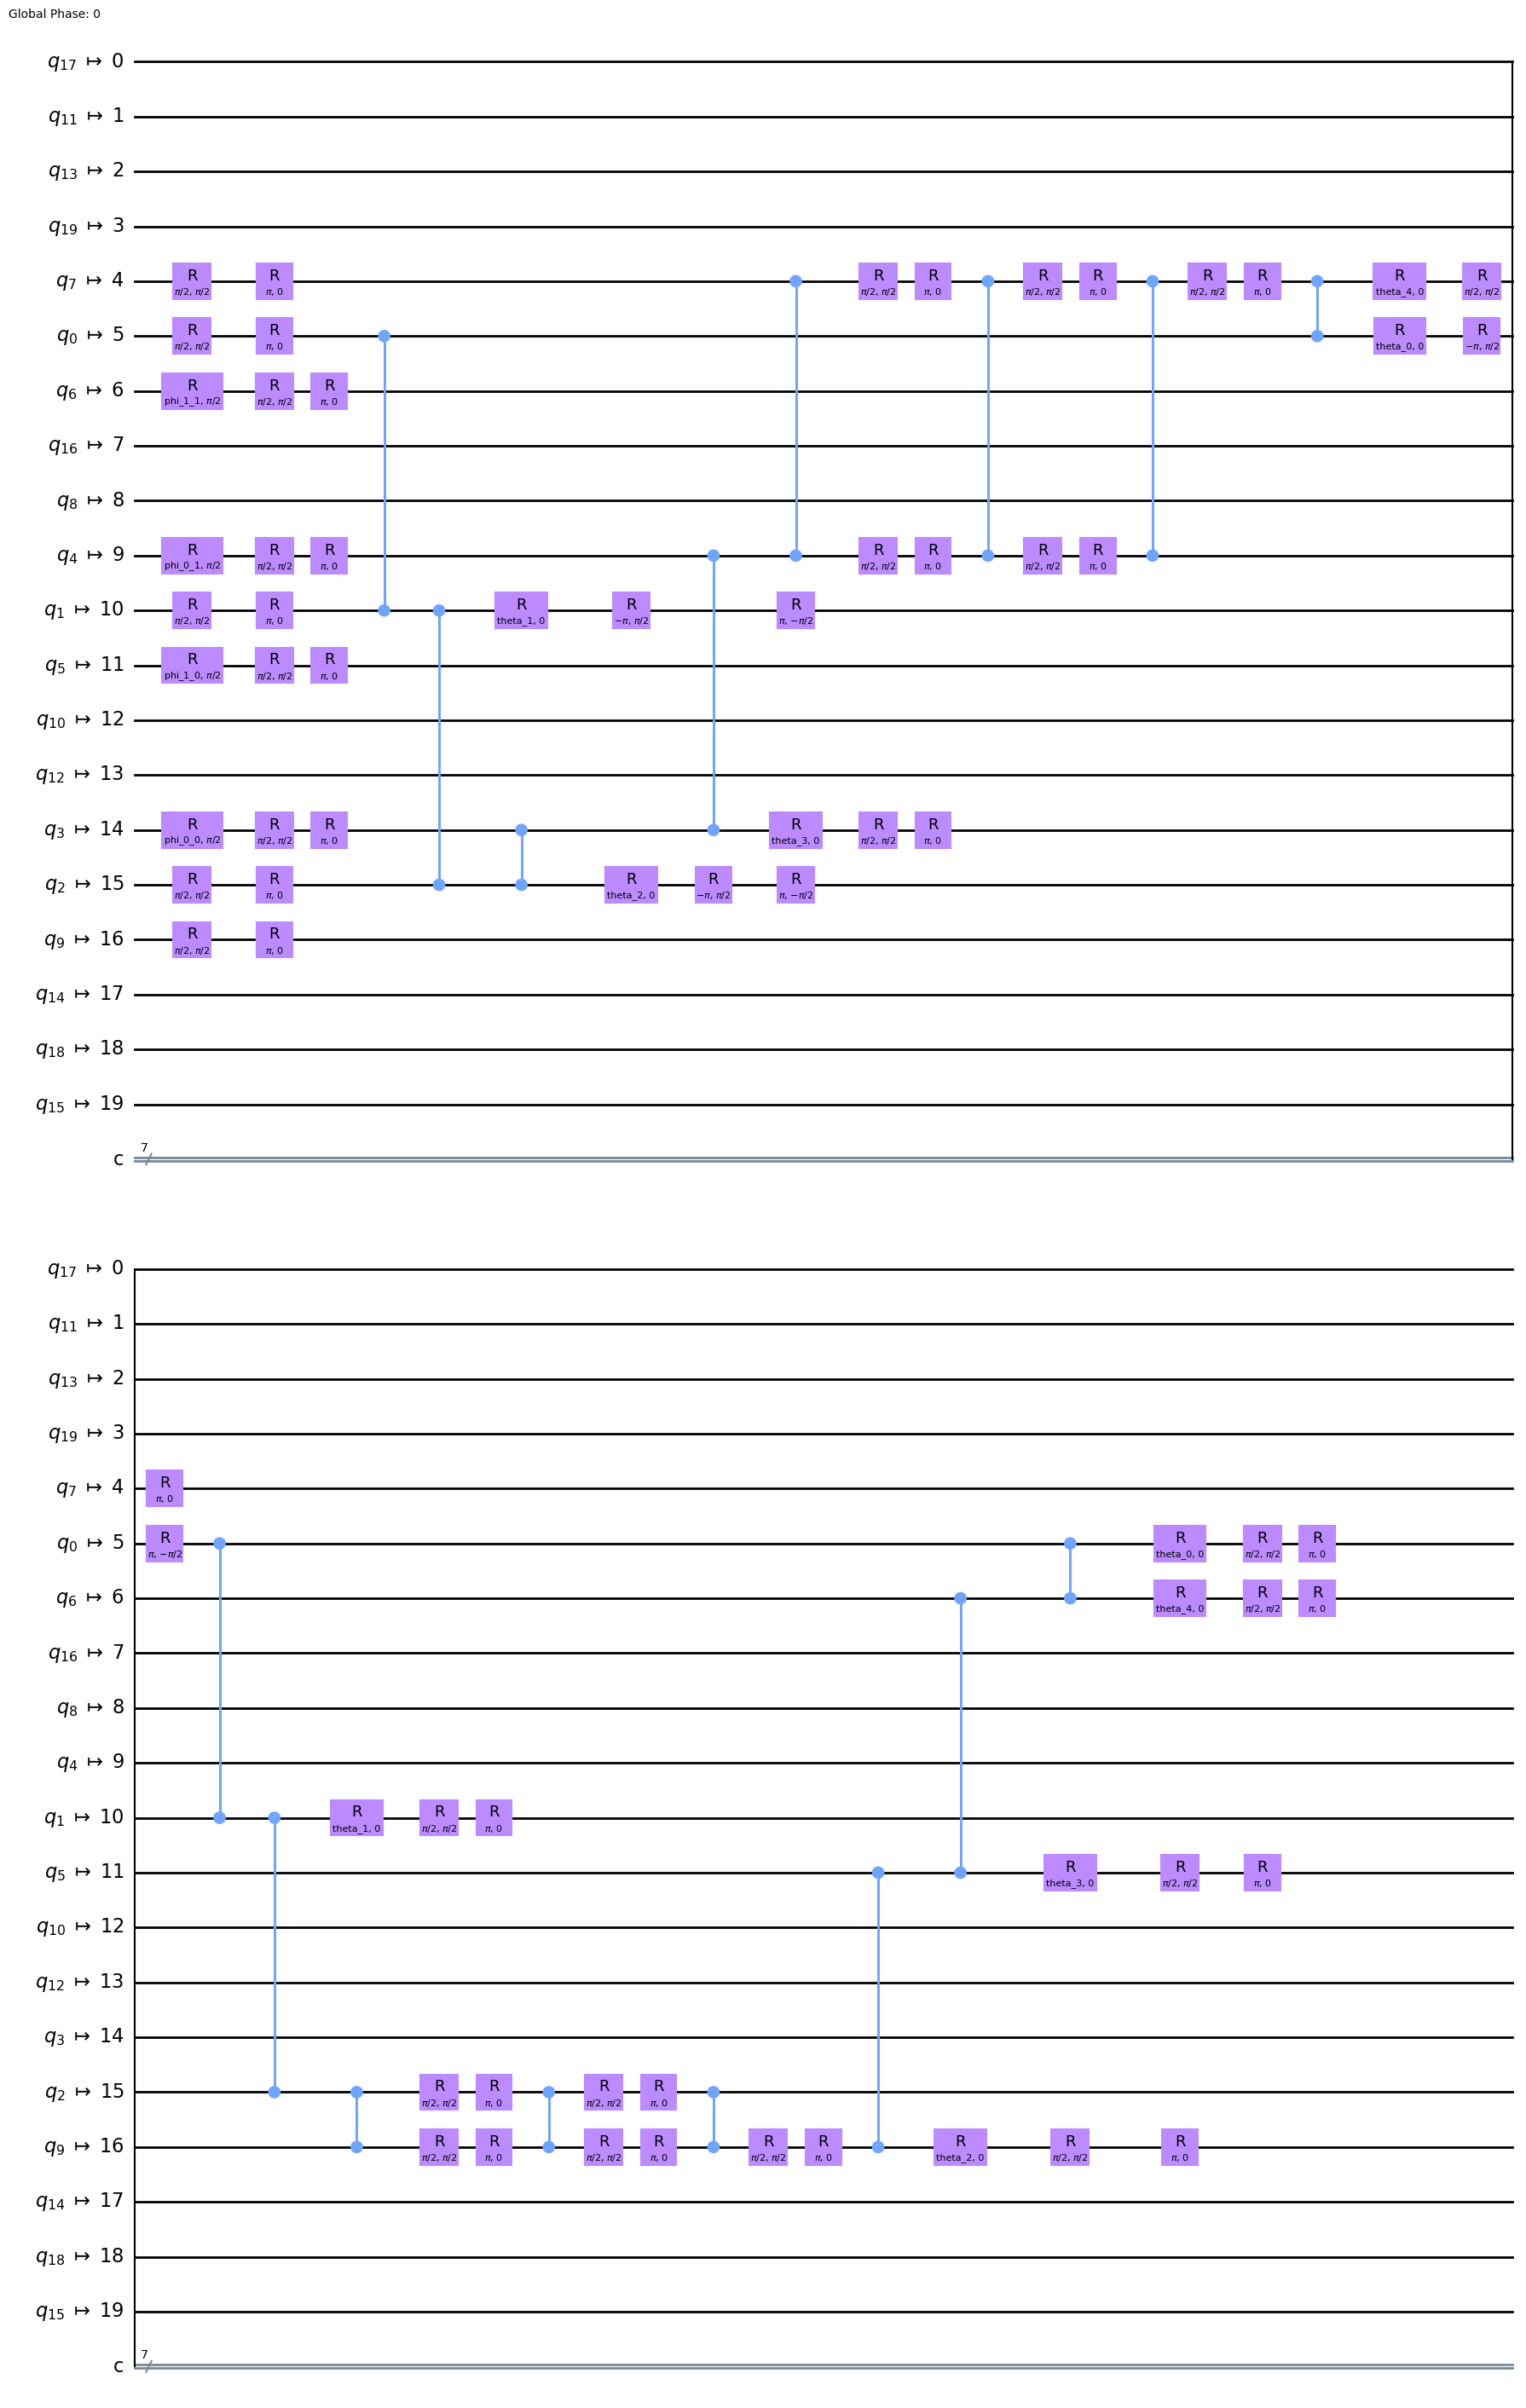

In [382]:
tqc2_space.draw('mpl')

In [383]:
tMeas2_space

[[14, 9], [5, 10, 15, 11, 6]]

In [395]:
X0,Y0,Z0,ev =Evaluate_Transpiled_Features(tqc2_space,tMeas2_space,3,2,2,phi2,theta2)

['IIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIZIIIIIIIIII', 'IIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIZIIIIZIIIII', 'IIIIIIZIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIZIIIIII', 'IIIIIZIIIIIIIIIIIIIIII', 'IIIIIIIIIIIZIIIIIIIIZI', 'IIIIIIIIIIZIIIIIIIIIII', 'IIIIIZIIIIIIIIIZIIIIII', 'IIIIIZIIIIZIIIIIIIIIII', 'IIIIIIZIIIIIIIIZIIIIIZ', 'IIIIIZZIIIIIIIIIIIIIIZ', 'IIIIIIIIIIZZIIIIIIIIZI', 'IIIIIIZIIIZIIIIIIIIIIZ', 'IIIIIIIIIIZIIIIZIIIIII', 'IIIIIIZIIIIZIIIIIIIIZZ', 'IIIIIIIIIIIZIIIZIIIIZI', 'IIIIIZIIIIIZIIIIIIIIZI', 'IIIIIIZIIIIZIIIZIIIIZZ', 'IIIIIZZIIIIZIIIIIIIIZZ', 'IIIIIIZIIIZIIIIZIIIIIZ', 'IIIIIZIIIIIZIIIZIIIIZI', 'IIIIIIZIIIZZIIIIIIIIZZ', 'IIIIIZIIIIZZIIIIIIIIZI', 'IIIIIZZIIIZIIIIIIIIIIZ', 'IIIIIZIIIIZIIIIZIIIIII', 'IIIIIIIIIIZZIIIZIIIIZI', 'IIIIIZZIIIIIIIIZIIIIIZ']


In [396]:
ZOPs=['IIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIZIIIIIIIIII', 'IIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIZIIIIZIIIII', 'IIIIIIZIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIZIIIIII', 'IIIIIZIIIIIIIIIIIIIIII', 'IIIIIIIIIIIZIIIIIIIIZI', 'IIIIIIIIIIZIIIIIIIIIII', 'IIIIIZIIIIIIIIIZIIIIII', 'IIIIIZIIIIZIIIIIIIIIII', 'IIIIIIZIIIIIIIIZIIIIIZ', 'IIIIIZZIIIIIIIIIIIIIIZ', 'IIIIIIIIIIZZIIIIIIIIZI', 'IIIIIIZIIIZIIIIIIIIIIZ', 'IIIIIIIIIIZIIIIZIIIIII', 'IIIIIIZIIIIZIIIIIIIIZZ', 'IIIIIIIIIIIZIIIZIIIIZI', 'IIIIIZIIIIIZIIIIIIIIZI', 'IIIIIIZIIIIZIIIZIIIIZZ', 'IIIIIZZIIIIZIIIIIIIIZZ', 'IIIIIIZIIIZIIIIZIIIIIZ', 'IIIIIZIIIIIZIIIZIIIIZI', 'IIIIIIZIIIZZIIIIIIIIZZ', 'IIIIIZIIIIZZIIIIIIIIZI', 'IIIIIZZIIIZIIIIIIIIIIZ', 'IIIIIZIIIIZIIIIZIIIIII', 'IIIIIIIIIIZZIIIZIIIIZI', 'IIIIIZZIIIIIIIIZIIIIIZ']

In [400]:
print([ZOPs[k][14]+ZOPs[k][9] for k in range(4)])
print([ZOPs[k][5]+ZOPs[k][10]+ZOPs[k][15]+ZOPs[k][11]+ZOPs[k][6] for k in range(4,9)])


['II', 'IZ', 'ZI', 'ZZ']
['IIIIZ', 'IIZII', 'ZIIII', 'IIIZI', 'IZIII']


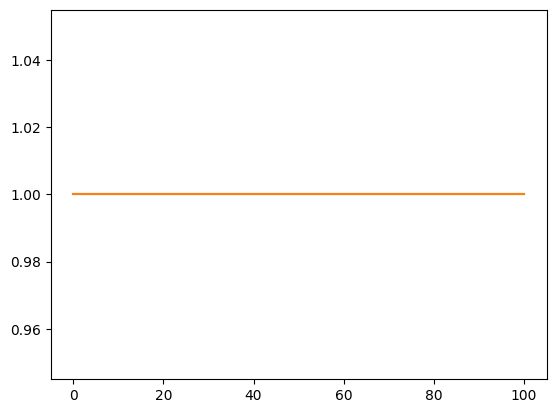

In [402]:
plt.plot(np.array(ZEV)[:,0])
plt.plot(np.array(ZEVS)[:,0])

#Permutations can occur..

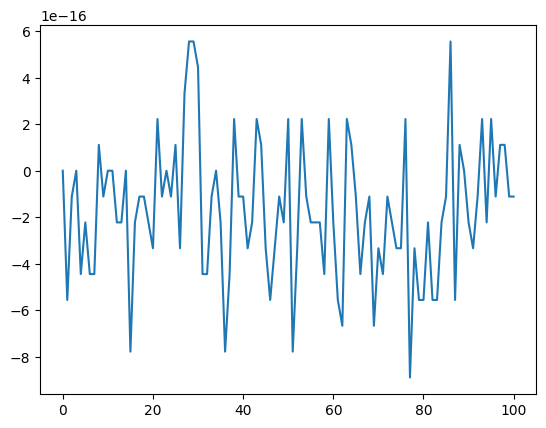

In [426]:
plt.plot(np.array(ZEV)[:,5]-np.array(ZEVS)[:,8])

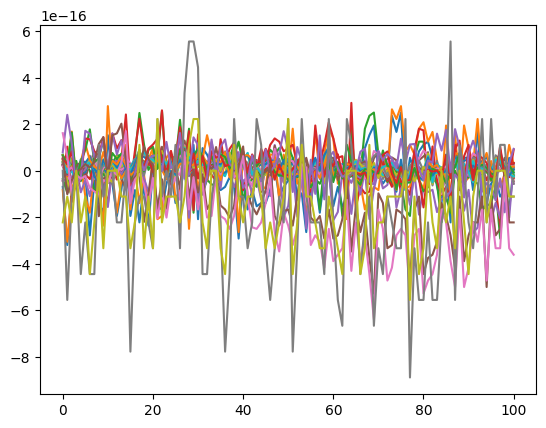

In [428]:
plt.plot(np.sort(np.array(ZEV),axis=1)-np.sort(np.array(ZEVS),axis=1))

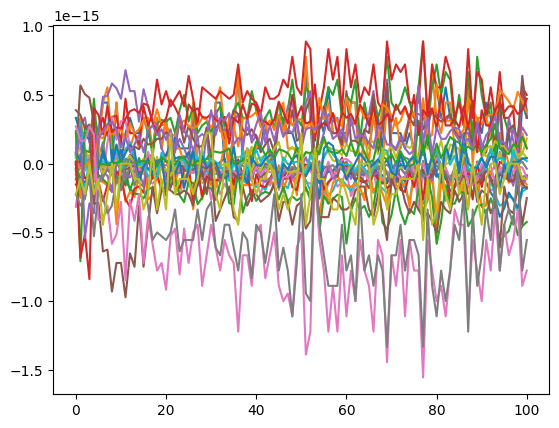

In [429]:
plt.plot(np.sort(np.array(XEV),axis=1)-np.sort(np.array(XEVS),axis=1))

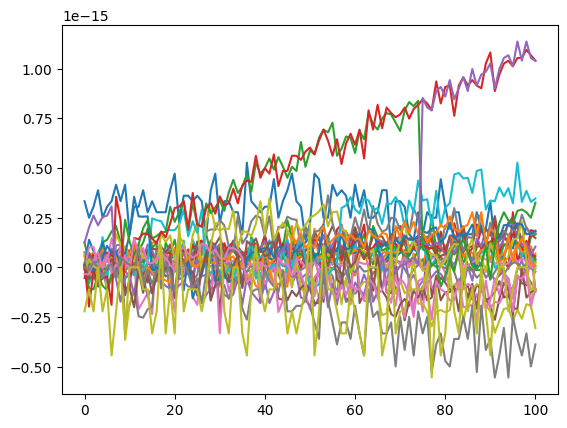

In [430]:
plt.plot(np.sort(np.array(YEV),axis=1)-np.sort(np.array(YEVS),axis=1))

In [493]:
[tqc3pre,tMeas3] = Simulated_Transpiled_Reservoir(2,'y')
tqc3post=optimize_single_qubit_gates(tqc3pre,drop_final_rz=False)
XEV3=[]
YEV3=[]
ZEV3=[]
for i in np.linspace(0,1,101):
    phi2=np.array([[np.pi*0.8,i],[np.pi*0.8,i]])
    theta2=np.array([2.84,-4.5,9.08,9.57,6.37])
    X0,Y0,Z0,ev =Evaluate_Transpiled_Features(tqc3post,tMeas3,3,2,2,phi2,theta2)
    XEV3.append(X0)
    YEV3.append(Y0)
    ZEV3.append(Z0)
[qc2,Meas2] = Simulated_Reservoir(2,'y')
XEVS=[]
YEVS=[]
ZEVS=[]
for i in np.linspace(0,1,101):
    phi2=np.array([[np.pi*0.8,i],[np.pi*0.8,i]])
    theta2=np.array([2.84,-4.5,9.08,9.57,6.37])
    X0,Y0,Z0,ev =Evaluate_Features(qc2,3,2,2,phi2,theta2)
    XEVS.append(X0)
    YEVS.append(Y0)
    ZEVS.append(Z0)

[[0, 1, 2, 3, 4], [0, 1, 2, 5, 6]]


/tmp/ipykernel_1463769/530722595.py:127: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  meas_mapping={perm_lib_qiskit[k].index:k for k in range(20)}


['IIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIZZIIII', 'IIIIIZIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIZIIIIIIIIIII', 'IIIIIIZIIIIIIIIIIIIIZI', 'IIIIIIIIIIIZIIIIIIIIII', 'IIIIIIIIIIZIIIIIZIIIII', 'IIIIIIIIIIZZIIIIIIIIII', 'IIIIIZIIIIIIIIIIZIIIIZ', 'IIIIIZIIIIZIIIIIIIIIIZ', 'IIIIIIZIIIIZIIIIIIIIZI', 'IIIIIZIIIIIZIIIIIIIIIZ', 'IIIIIIIIIIIZIIIIZIIIII', 'IIIIIZZIIIIIIIIIIIIIZZ', 'IIIIIIZIIIIIIIIIZIIIZI', 'IIIIIIZIIIZIIIIIIIIIZI', 'IIIIIZZIIIIIIIIIZIIIZZ', 'IIIIIZZIIIZIIIIIIIIIZZ', 'IIIIIZIIIIIZIIIIZIIIIZ', 'IIIIIIZIIIZIIIIIZIIIZI', 'IIIIIZZIIIIZIIIIIIIIZZ', 'IIIIIIZIIIZZIIIIIIIIZI', 'IIIIIZIIIIZZIIIIIIIIIZ', 'IIIIIIIIIIZZIIIIZIIIII', 'IIIIIIZIIIIZIIIIZIIIZI', 'IIIIIZIIIIZIIIIIZIIIIZ']
['IIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIZZIIII', 'IIIIIZIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIZIIIIIIIIIII', 'IIIIIIZIIIIIIIIIIIIIZI', 'IIIIIIIIIIIZIIIIIIIIII', 'IIIIIIIIIIZIIIIIZIIIII', 

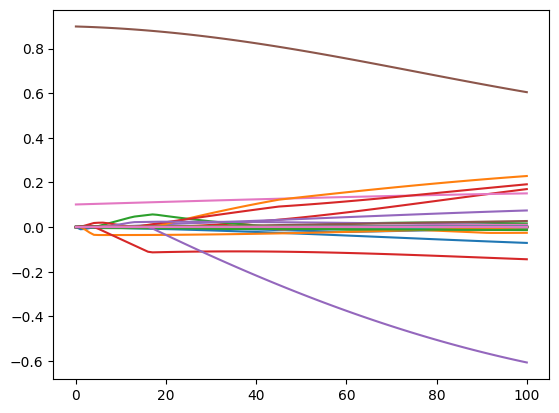

In [515]:
plt.plot(np.sort(np.array(YEV3),axis=1)-np.sort(np.array(YEVS),axis=1))
plt.plot(np.sort(np.array(ZEV3),axis=1)-np.sort(np.array(ZEVS),axis=1))
plt.plot(np.sort(np.array(XEV3),axis=1)-np.sort(np.array(XEVS),axis=1))

In [495]:
phi=np.array([[np.pi*0.8,0.7],[np.pi*0.8,0.7]])
theta=np.array([2.84,-4.5,9.08,9.57,6.37])
circ_trans=tqc3pre
circ_sq=tqc3post
param_map_trans={k.name:k for k in circ_trans.parameters}
param_map_sq={k.name:k for k in circ_sq.parameters}
shape_phi=phi.shape

phi_assignment_trans={param_map_trans['phi_%s_%s' % (k,s)]:phi[k,s] for k in range(shape_phi[0]) for s in range(shape_phi[1])}
theta_assignment_trans={param_map_trans['theta_%s' % k]:theta[k] for k in range(len(theta))}

phi_assignment_sq={param_map_sq['phi_%s_%s' % (k,s)]:phi[k,s] for k in range(shape_phi[0]) for s in range(shape_phi[1])}
theta_assignment_sq={param_map_sq['theta_%s' % k]:theta[k] for k in range(len(theta))}

explicit_val_trans=circ_trans.assign_parameters(phi_assignment_trans)
explicit_val_trans=explicit_val_trans.assign_parameters(theta_assignment_trans)
explicit_val_trans.save_statevector()
backend = AerSimulator(method='statevector')
job = execute(explicit_val_trans, backend=backend, shots=1, memory=True)
job_result = job.result()
strans=job_result.get_statevector(explicit_val_trans)

explicit_val_sq=circ_sq.assign_parameters(phi_assignment_sq)
explicit_val_sq=explicit_val_sq.assign_parameters(theta_assignment_sq)
explicit_val_sq.save_statevector()
backend = AerSimulator(method='statevector')
job_sq = execute(explicit_val_sq, backend=backend, shots=1, memory=True)
job_result_sq = job_sq.result()
ssq=job_result_sq.get_statevector(explicit_val_sq)

In [505]:
np.linalg.norm(np.array(strans)-np.array(ssq))

2.7877249968517012e-15

In [497]:
ssq

Statevector([0.04661704+0.12030221j, 0.        +0.j        ,
             0.        +0.j        , ..., 0.        +0.j        ,
             0.        +0.j        , 0.        +0.j        ],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))


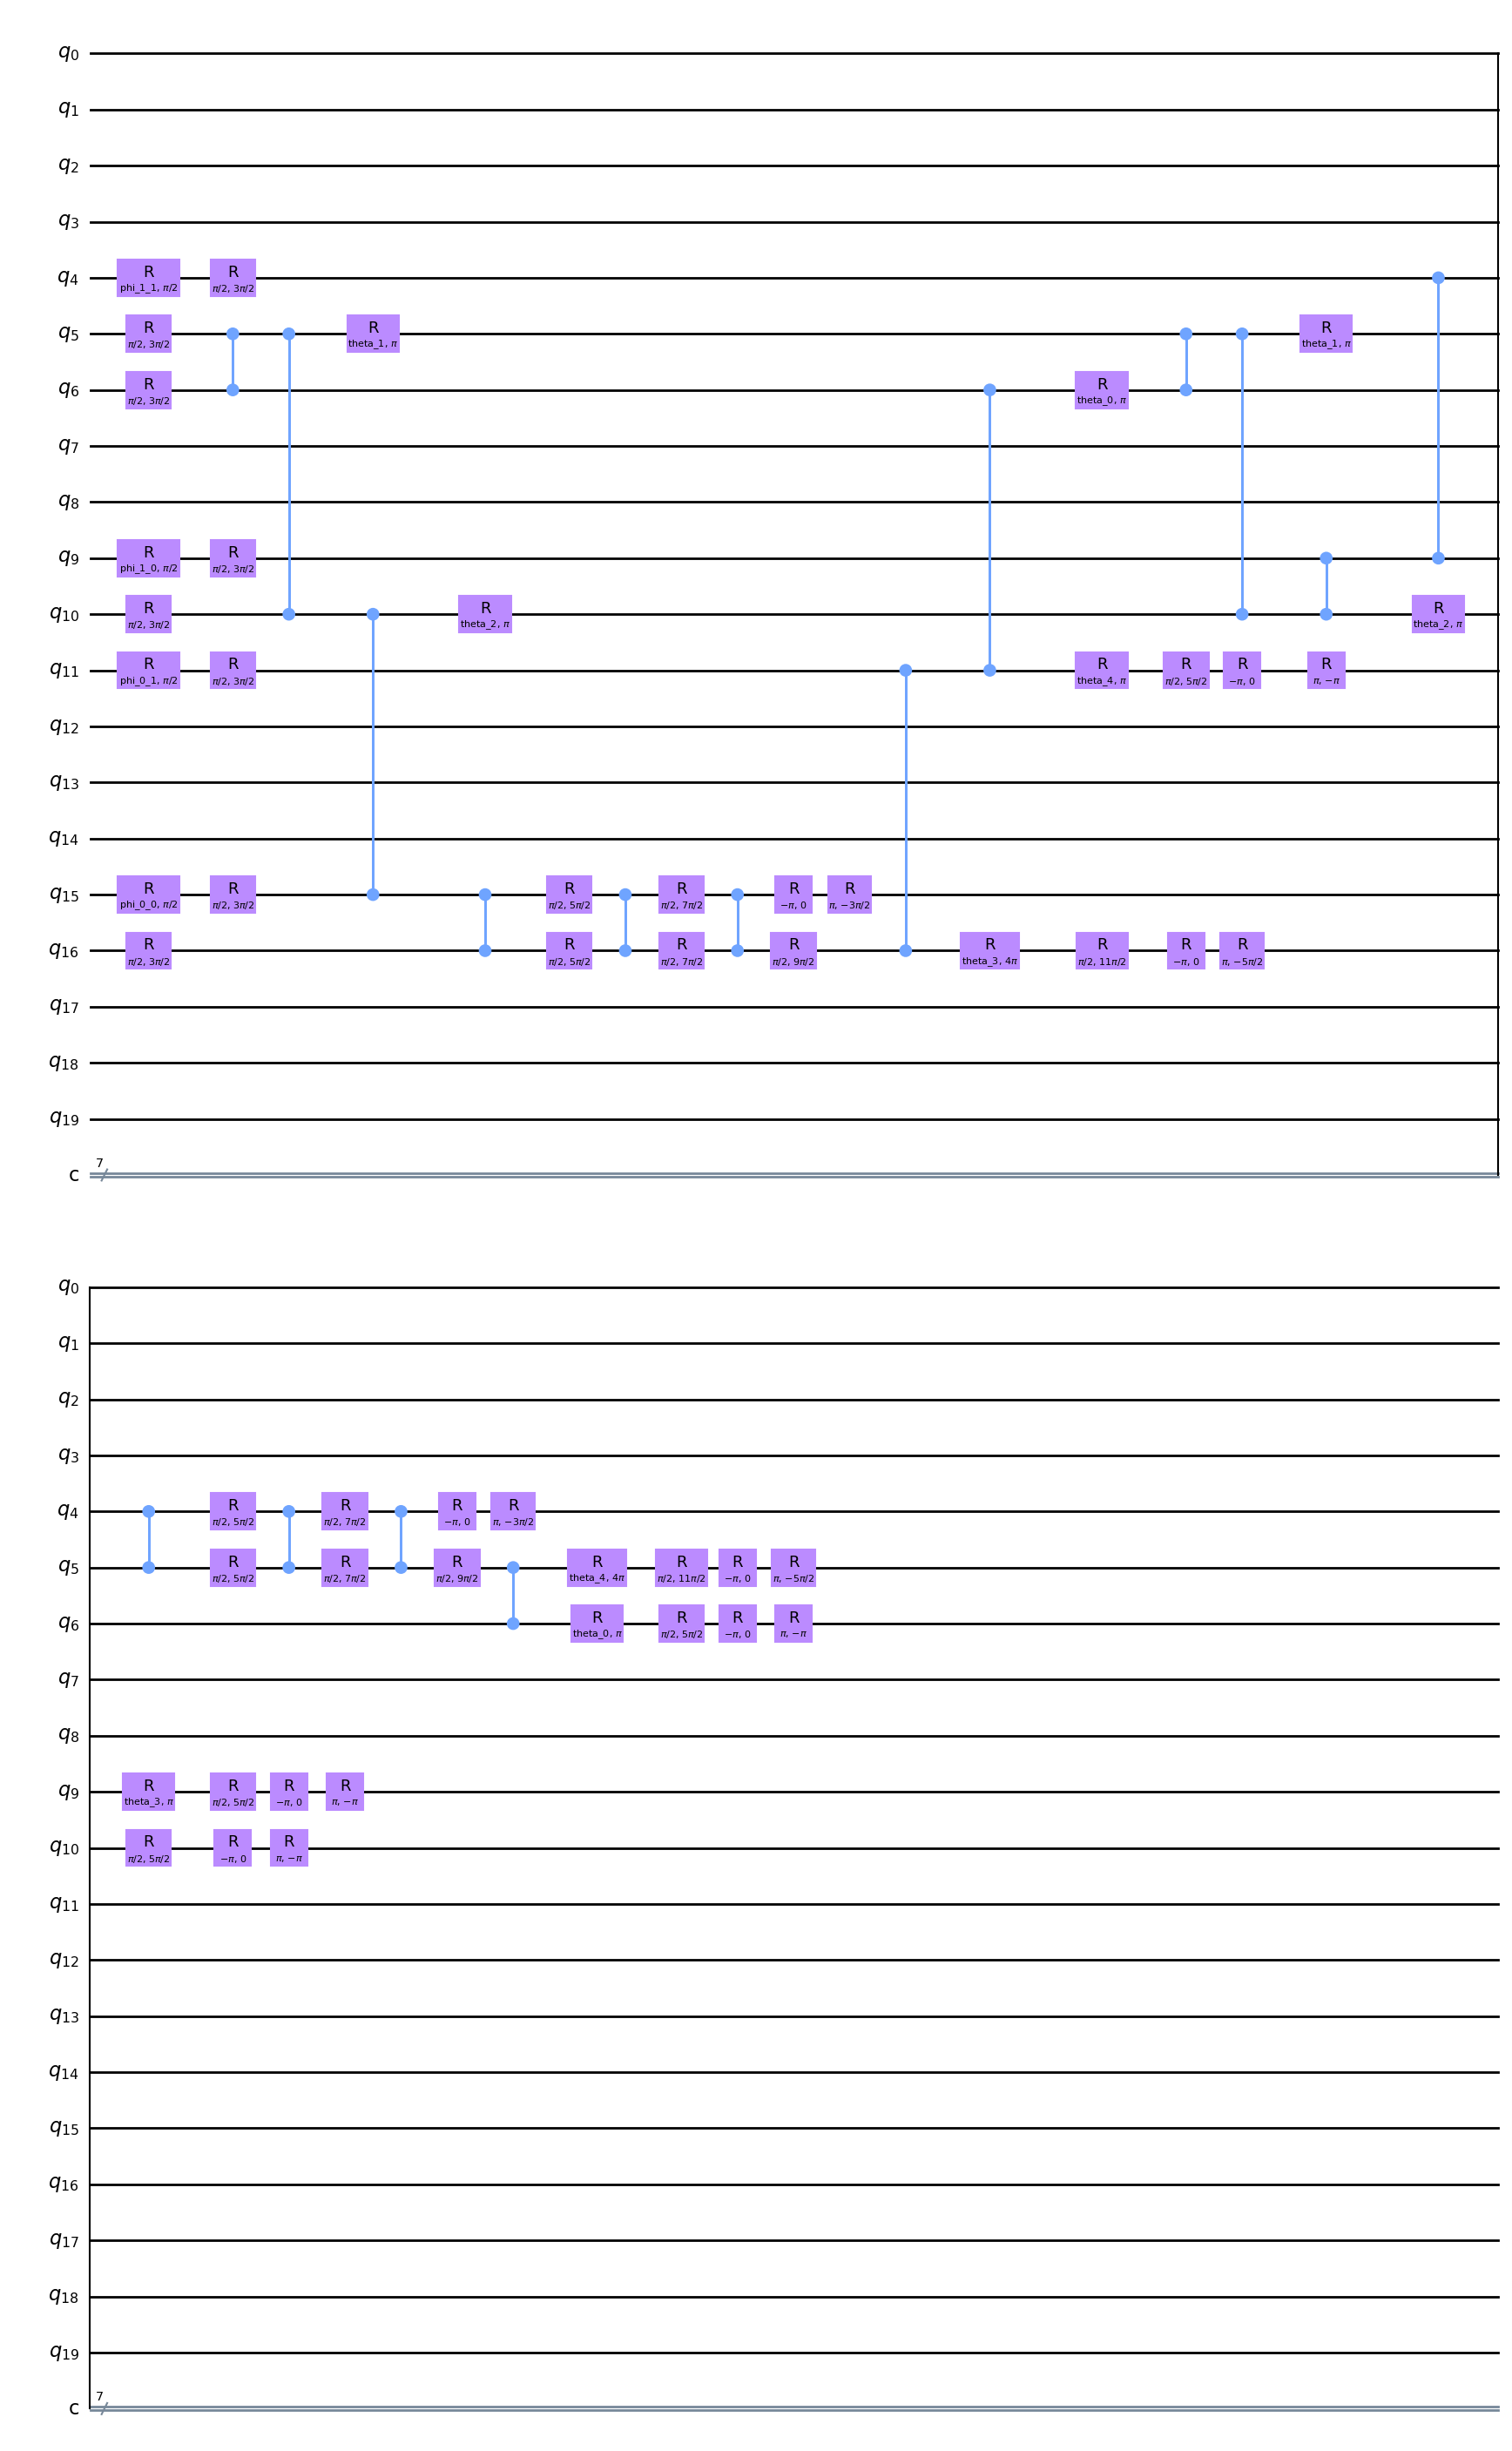

In [492]:
tqc3.draw('mpl')

array([-4.39474574e-17,  5.30844018e-17,  1.61754494e-16,  1.47802167e-16,
       -2.16091657e-16, -1.23522815e-16, -2.22905190e-17, -1.70738125e-16,
        6.56603000e-17, -6.04349538e-17, -1.95579908e-17, -6.29226895e-17,
       -6.92144503e-17,  1.04896560e-17, -1.20295619e-17,  1.58844089e-17,
       -8.57222754e-17, -1.50393241e-16,  3.14206872e-17, -1.37397214e-16,
       -7.80540861e-18, -1.30709042e-16, -3.13675782e-16, -9.78450109e-17,
       -2.07057204e-17, -1.01061195e-16, -2.43544842e-16, -1.11967591e-16,
       -3.47707025e-18, -1.73618037e-16, -1.21447584e-16, -2.93852670e-17,
       -2.09449225e-16, -3.05488362e-16, -1.96808105e-16,  6.39645400e-17,
       -1.55372101e-16, -1.59498845e-16,  2.22312267e-17, -2.20901957e-16,
       -7.68496052e-17, -1.94145034e-16,  1.88007433e-17, -4.68375339e-17,
        1.12223395e-17, -3.03900175e-16, -1.16915958e-16, -2.42143003e-16,
       -2.10098052e-16,  2.70711730e-18, -3.53094154e-17, -1.38171402e-16,
       -8.85640709e-17, -

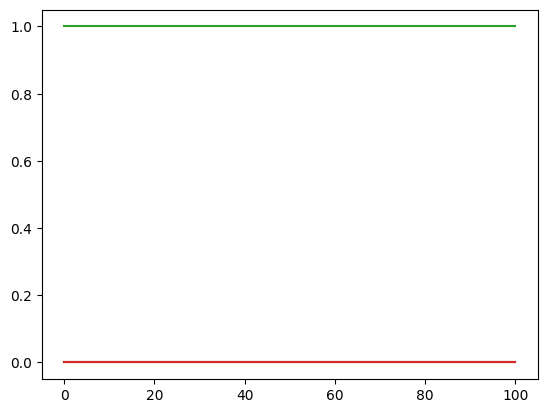

In [477]:
plt.plot((np.array(ZEV3)[:,0:4]-np.array(ZEVS)[:,0:4]))


[[3, 9], [4, 1, 0, 8, 2]]


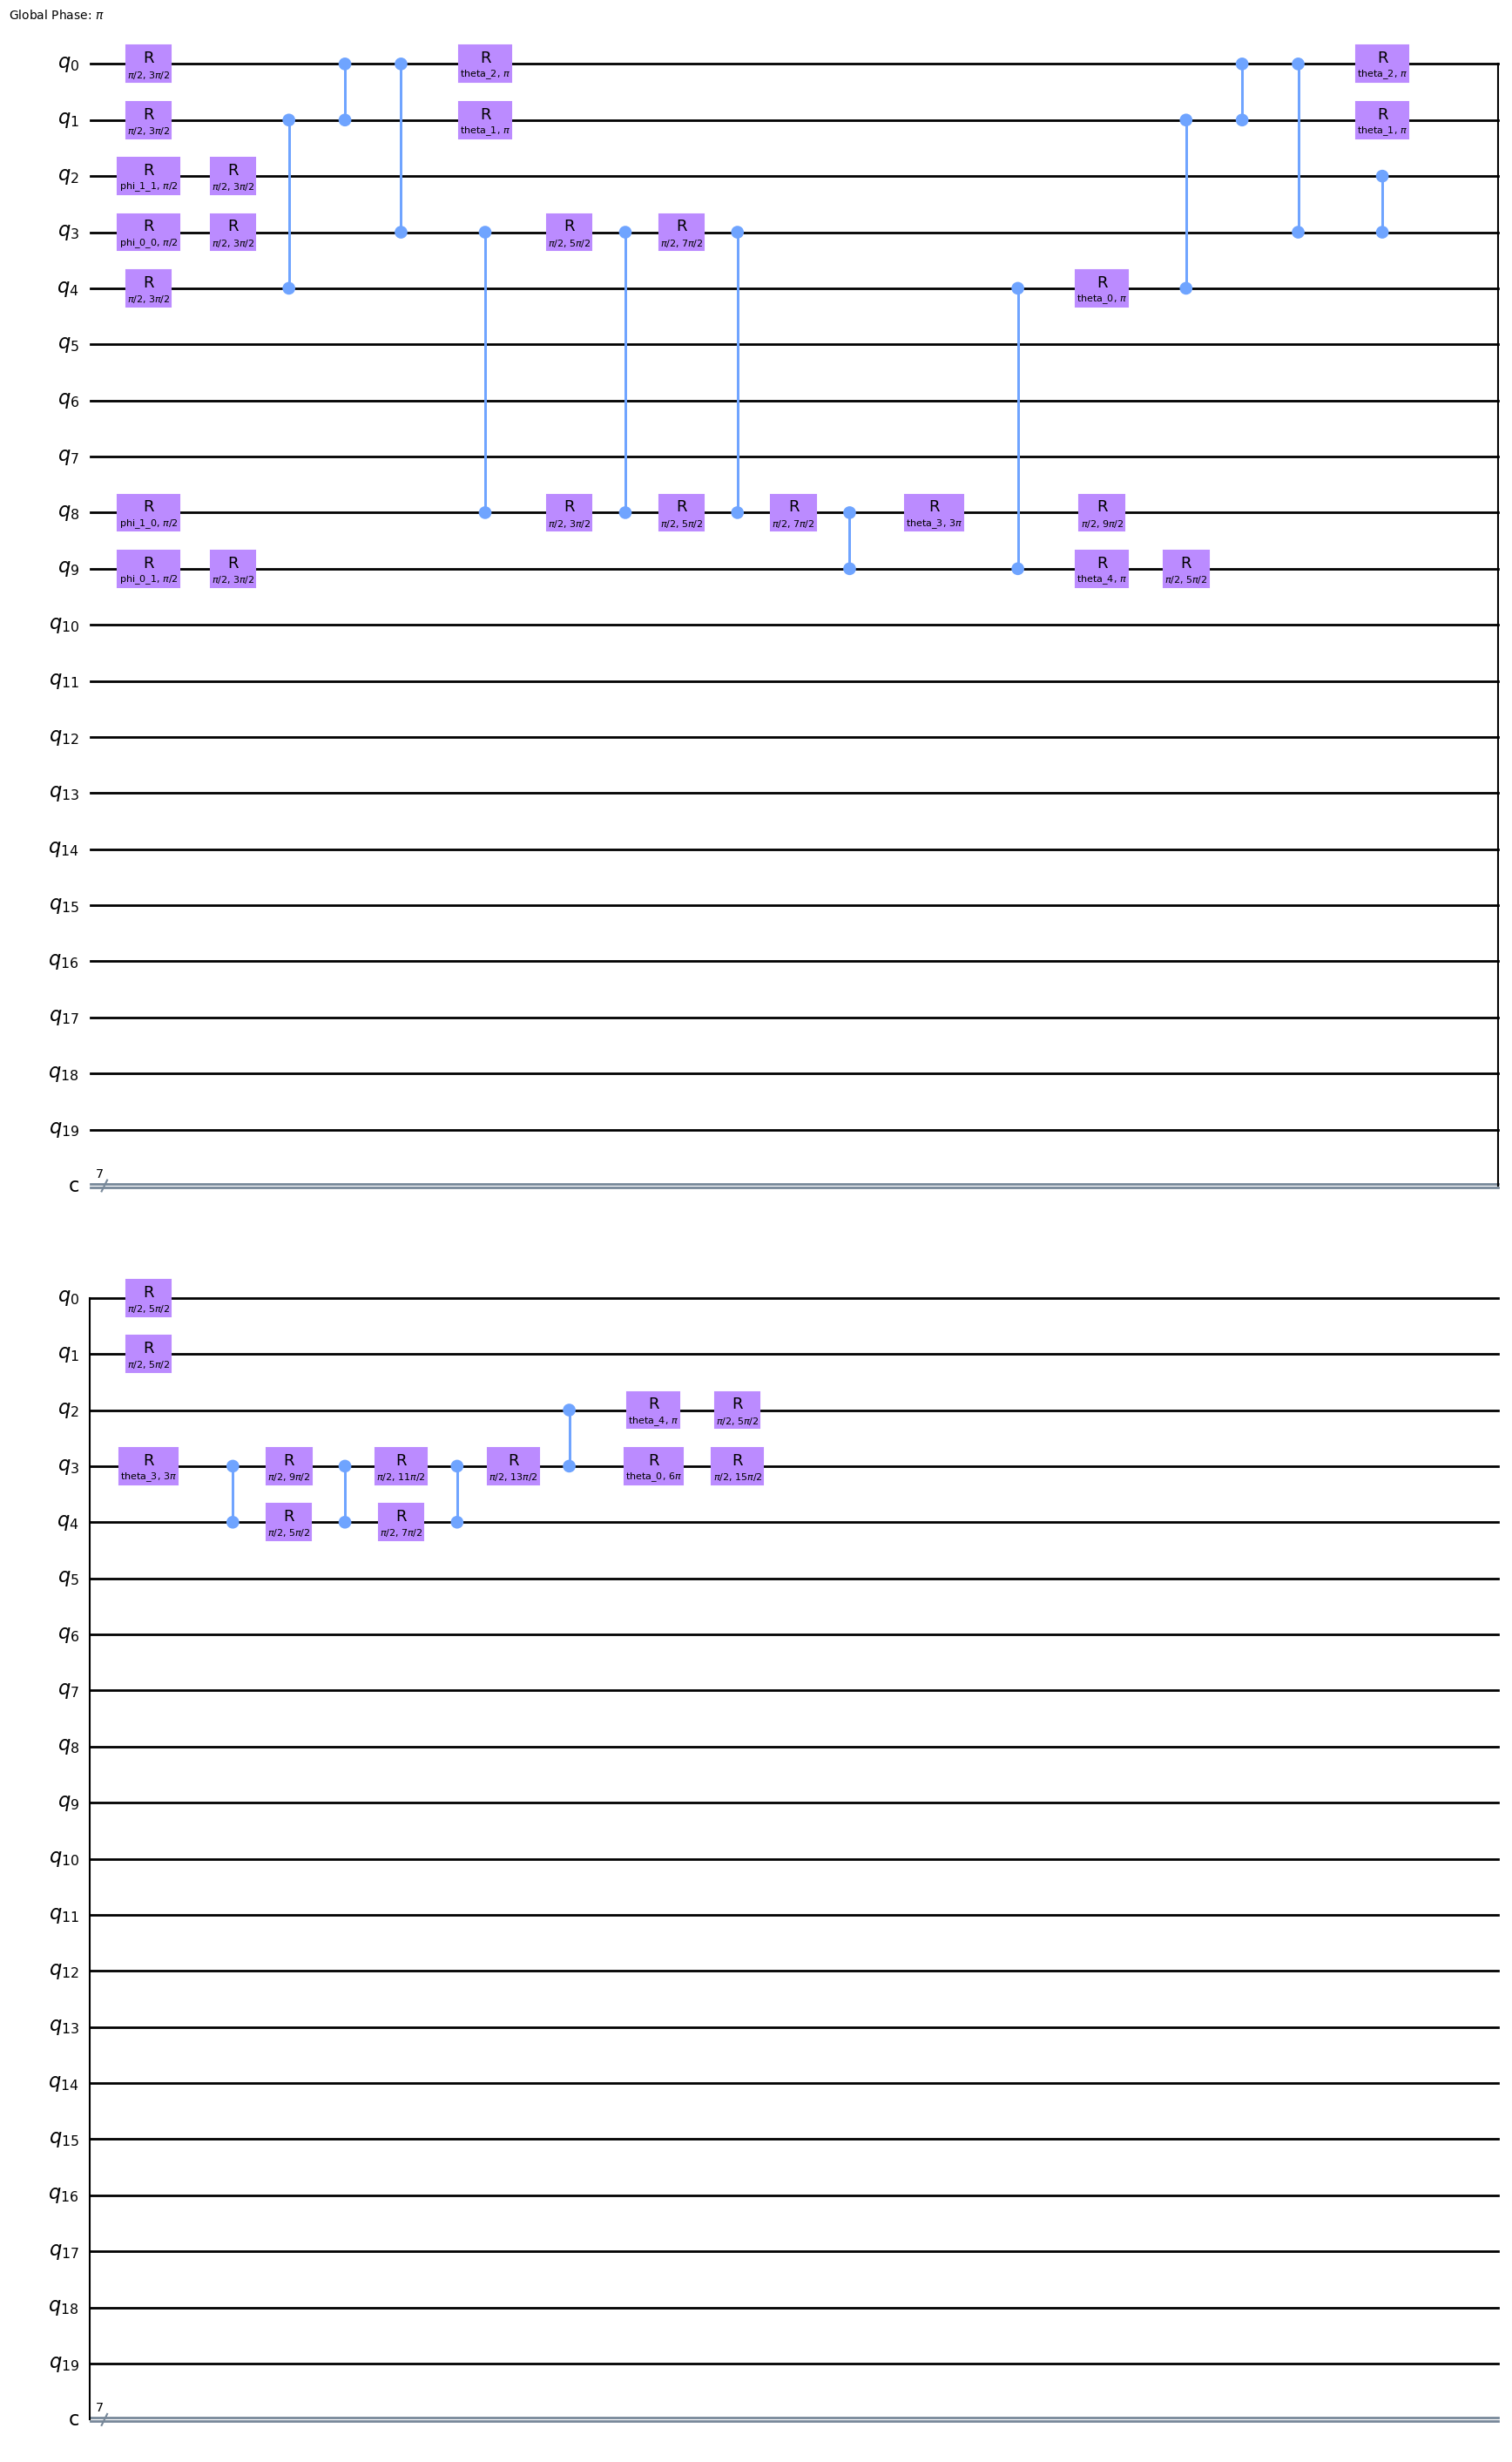

In [447]:
print(tMeas3)
tqc3.draw('mpl')

[[14, 9], [5, 10, 15, 11, 6]]


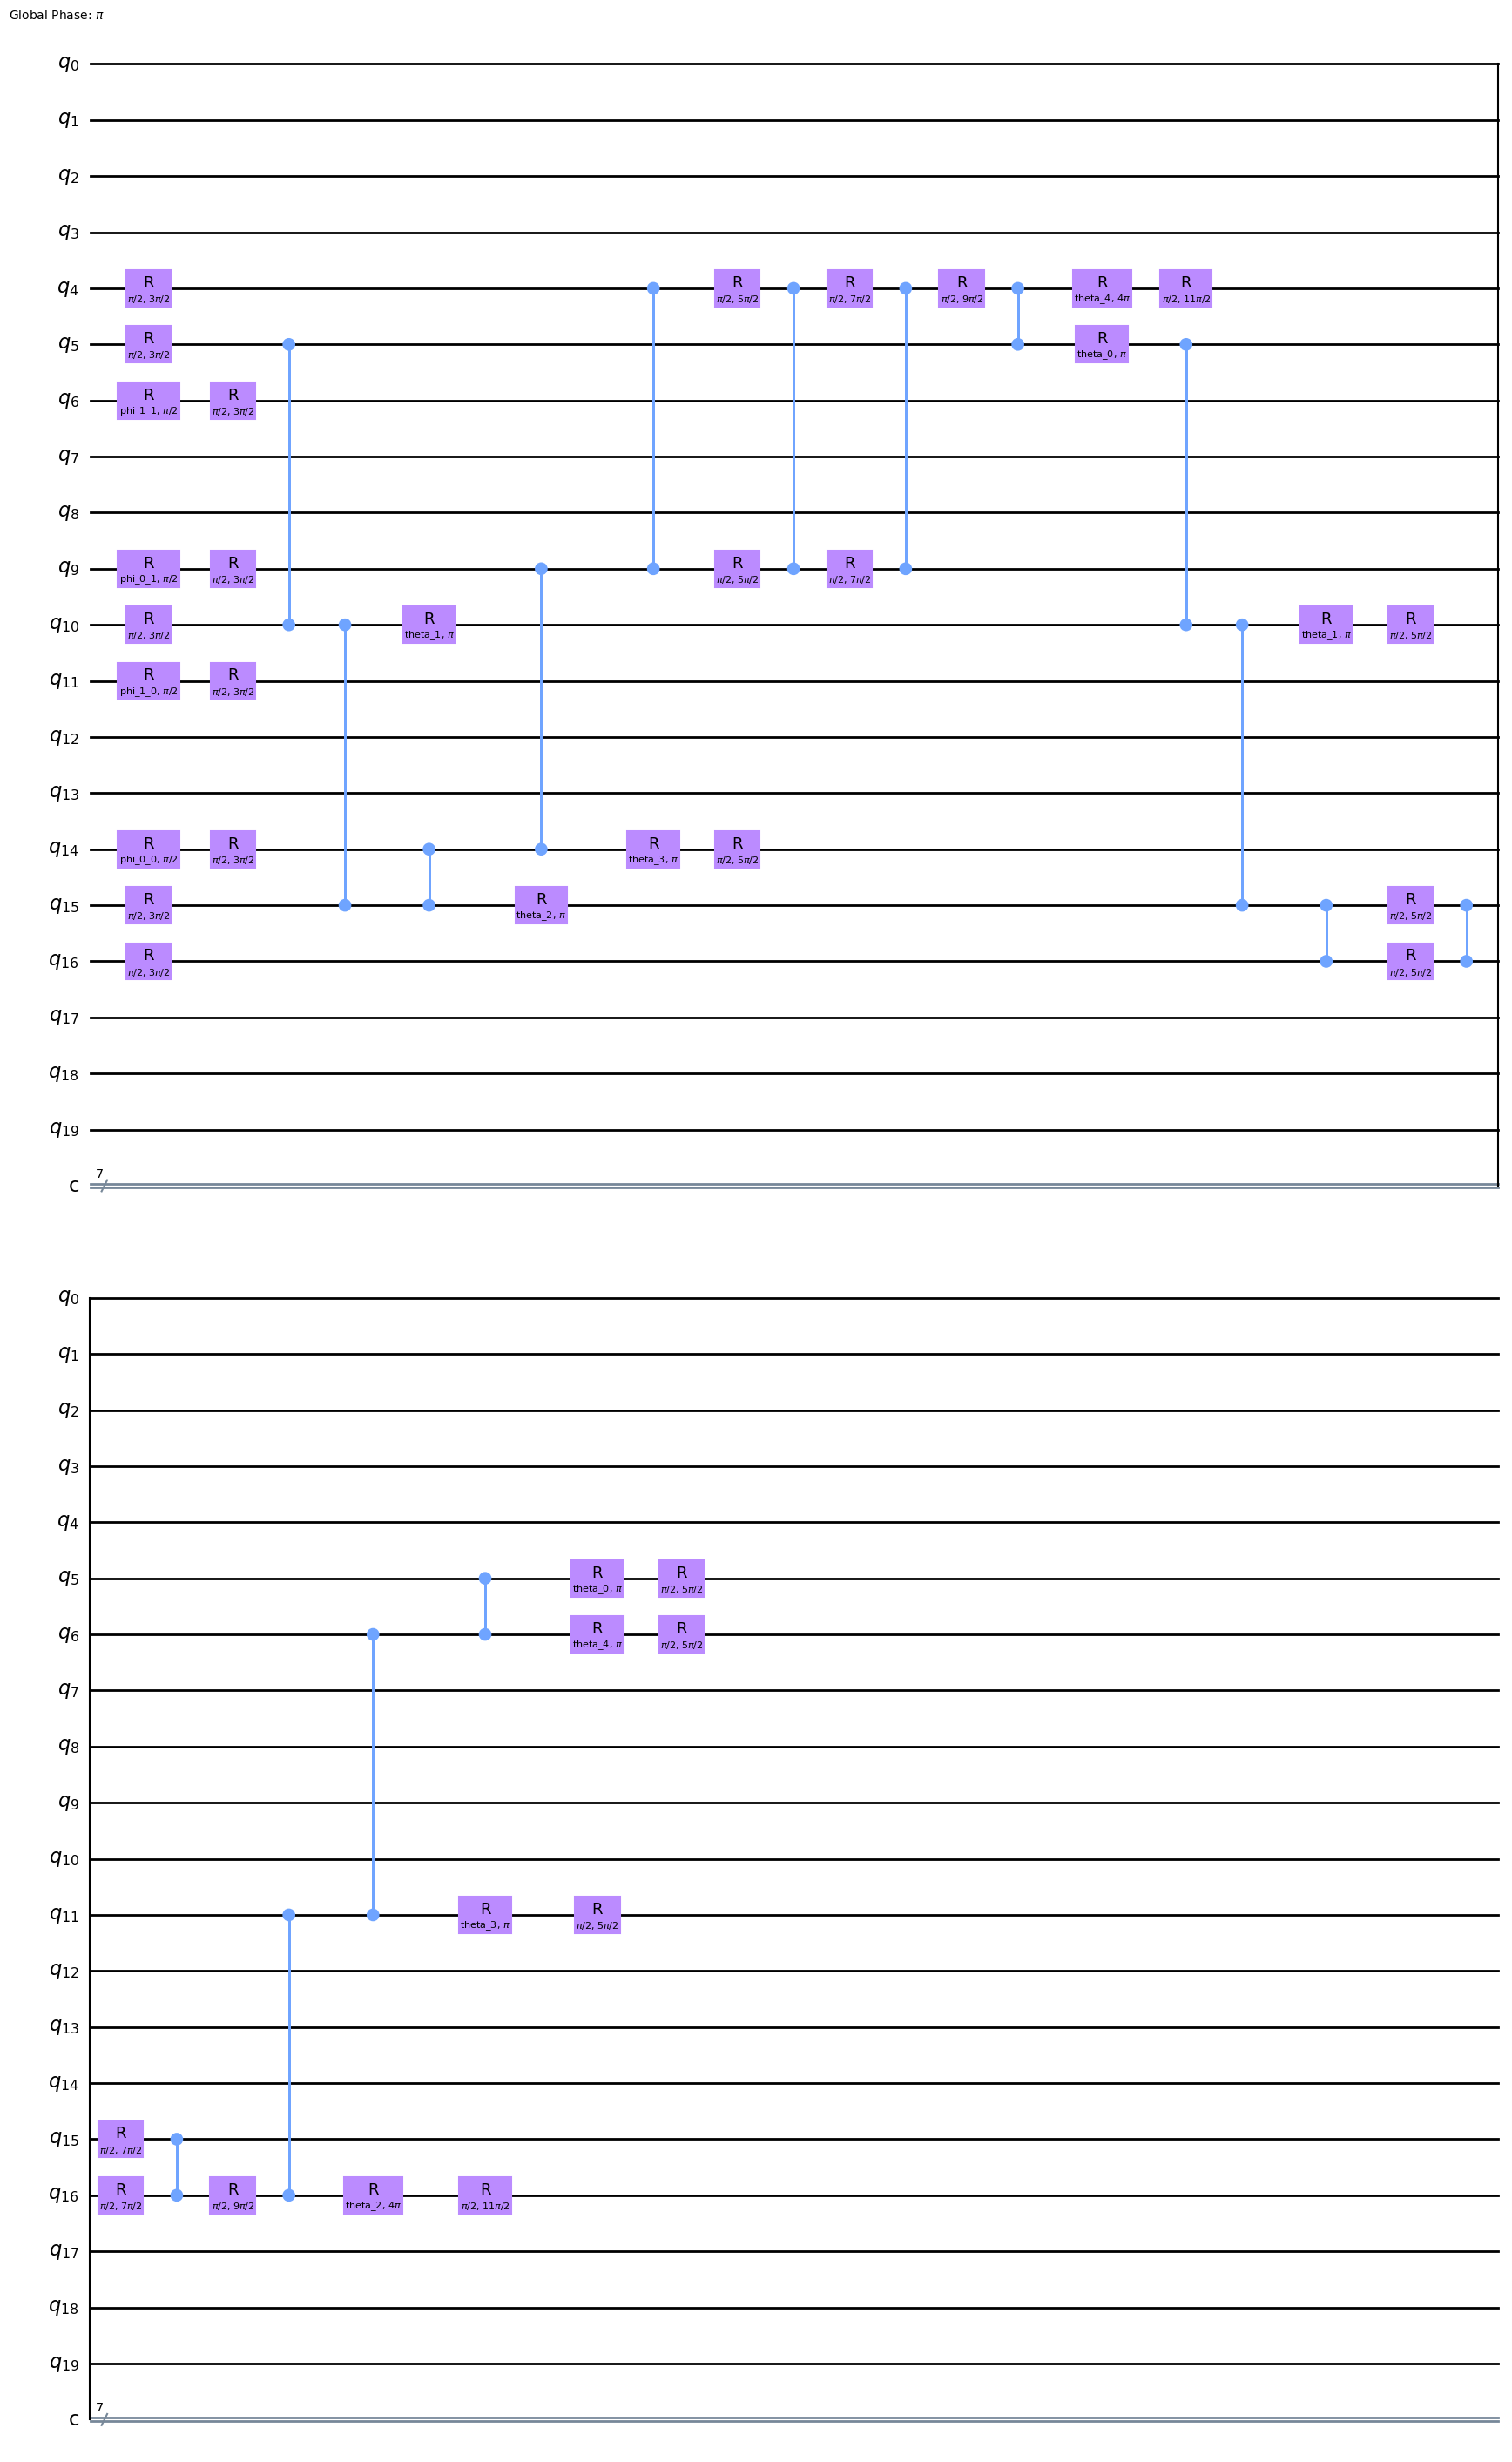

In [451]:
print(tMeas2_space) # version 13.7
optimize_single_qubit_gates(tqc2_space).draw('mpl')

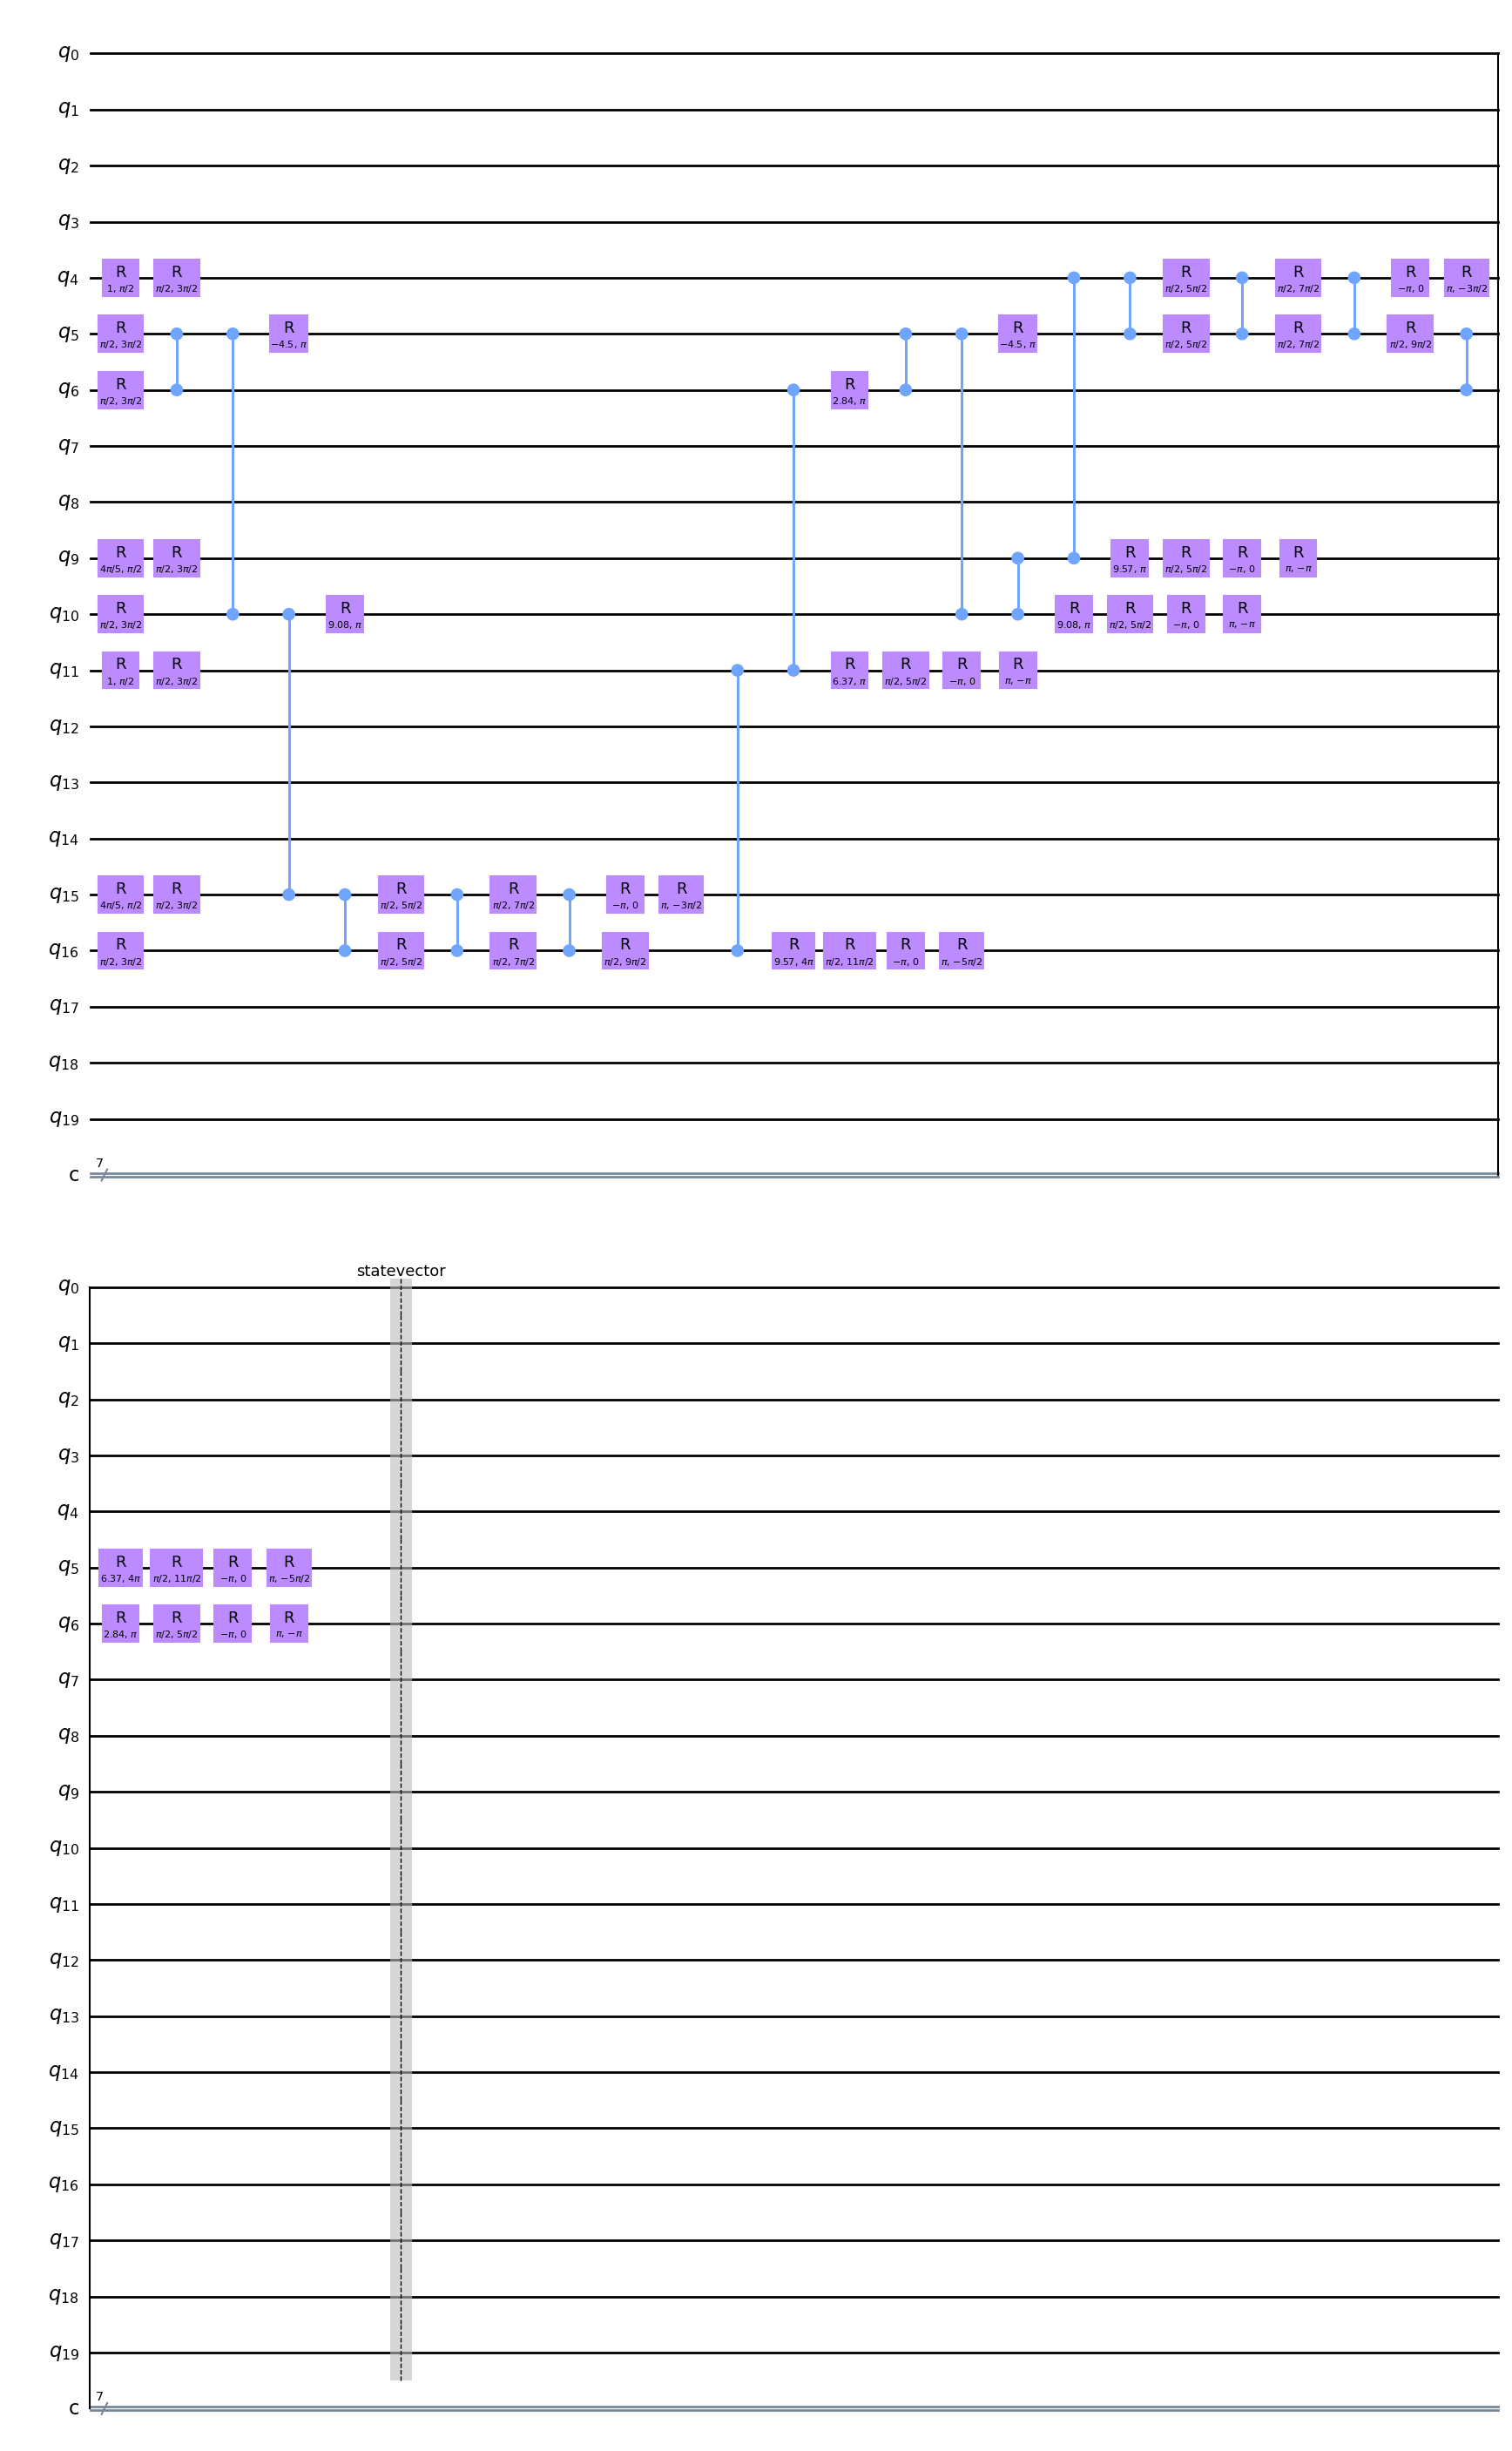

In [480]:
ev.draw('mpl')

In [4]:
phi2=np.array([[np.pi*0.8,0.7],[np.pi*0.8,0.7]])
theta2=np.array([2.84,-4.5,9.08,9.57,6.37])
X0,Y0,Z0,ev,sv2,ZL =Evaluate_Transpiled_Features(tqc3post,tMeas3,3,2,2,phi2,theta2)

NameError: name 'tqc3post' is not defined

In [512]:
np.linalg.norm(sv2-strans)

2.7877249968517012e-15

In [514]:
np.sort(np.array([0.01,1,-1]))

array([-1.  ,  0.01,  1.  ])